In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats
from scipy.interpolate import griddata

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('2016 School NYC.csv')
df.head(2)

Adjusted Grade New? Other Location Code in LCGMS  \
0            NaN    x                          NaN   
1            NaN    x                          NaN   

                                     School Name      SED Code Location Code  \
0                           THE PECK SLIP SCHOOL  3.102000e+11        02M343   
1  P.S. 527 - EAST SIDE SCHOOL FOR SOCIAL ACTION  3.102000e+11        02M527   

   District   Latitude  Longitude                    Address (Full)  \
0         2  40.708639 -74.001925    1 PECK SLIP NEW YORK, NY 10038   
1         2  40.780580 -73.947910  323 E 91ST ST NEW YORK, NY 10128   

                      ...                       \
0                     ...                        
1                     ...                        

  Grade 8 Math - All Students Tested  Grade 8 Math 4s - All Students  \
0                                  0                               0   
1                                  0                               0   

  Grade 8 Math 4s - American Indian or Alaska Native  \
0                                                  0   
1                                                  0   

  Grade 8 Math 4s - Black or African American  \
0                                           0   
1                                           0   

  Grade 8 Math 4s - Hispanic or Latino  \
0                                    0   
1                                    0   

  Grade 8 Math 4s - Asian or Pacific Islander  Grade 8 Math 4s - White  \
0                                           0                        0   
1                                           0                        0   

  Grade 8 Math 4s - Multiracial Grade 8 Math 4s - Limited English Proficient  \
0                             0                                            0   
1                             0                                            0   

  Grade 8 Math 4s - Economically Disadvantaged  
0                                            0  
1                                            0  

[2 rows x 161 columns]

In this notebook we will focus on all NYC schools up to 8th grade

In [3]:
# df = df[(df['Grade High']=='08')& (df['City']=='BROOKLYN')]
df = df[(df['Grade High']=='8')]

In [4]:
df1 = df.copy()
df1 = df1[['Grade High','Economic Need Index','School Income Estimate','Percent Black / Hispanic','Percent White',
           'Percent of Students Chronically Absent','Average ELA Proficiency','Grade 6 Math - All Students Tested',
           'Grade 6 Math 4s - All Students', 'Supportive Environment Rating', 'Effective School Leadership Rating', 
           'Trust Rating','Student Achievement Rating','Percent Black','Percent Hispanic','Trust %', 
           'Collaborative Teachers %', 'Average Math Proficiency','Supportive Environment %','School Name']]

In [5]:
# Create column for percent of students that received a 4 in math from all students that took the exam.
df1['prcnt_sdnt_math_4s'] = (df1['Grade 6 Math 4s - All Students'] / df1['Grade 6 Math - All Students Tested']).round(3)

In [6]:
# convert data to floats
df1['Percent of Students Chronically Absent'] = df1['Percent of Students Chronically Absent'].str.rstrip('%').astype(float)
df1['Percent Black'] = df1['Percent Black'].str.rstrip('%').astype(float)
df1['Percent Hispanic'] = df1['Percent Hispanic'].str.rstrip('%').astype(float)

df1['Trust %'] = df1['Trust %'].str.rstrip('%').astype(float)
df1['Supportive Environment %'] = df1['Supportive Environment %'].str.rstrip('%').astype(float)
df1['Collaborative Teachers %'] = df1['Collaborative Teachers %'].str.rstrip('%').astype(float)
df1['Percent White'] = df1['Percent White'].str.rstrip('%').astype(float)
df1['School Income Estimate'] = df1['School Income Estimate'].str.strip('$')
df1['School Income Estimate'] = df1['School Income Estimate'].str.replace(",","").astype(float)

# drop the Null row
df1.dropna(subset=['Economic Need Index','prcnt_sdnt_math_4s'],inplace=True)

In [7]:
# create dataframe of rows of schools with a majority of white or black students ( over 50% black students or over 50% white)
df1 = df1[(df1['Percent Black']>50) | (df1['Percent White']>50) | (df1['Percent Hispanic']>50)]

In [8]:
# Create race columns where the majority of students from each race represent the school

def f(row):
    if row['Percent Black'] > 50:
        val = 'African American'
    elif row['Percent White'] > 50:
        val = 'White'
    elif row['Percent Hispanic'] > 50:
        val = 'Hispanic'
    return val

df1['race'] = df1[['Percent Black','Percent White','Percent Hispanic']].apply(f, axis=1)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 28 to 1258
Data columns (total 22 columns):
Grade High                                338 non-null object
Economic Need Index                       338 non-null float64
School Income Estimate                    126 non-null float64
Percent Black / Hispanic                  338 non-null object
Percent White                             338 non-null float64
Percent of Students Chronically Absent    338 non-null float64
Average ELA Proficiency                   338 non-null float64
Grade 6 Math - All Students Tested        338 non-null int64
Grade 6 Math 4s - All Students            338 non-null int64
Supportive Environment Rating             328 non-null object
Effective School Leadership Rating        331 non-null object
Trust Rating                              332 non-null object
Student Achievement Rating                332 non-null object
Percent Black                             338 non-null float64
Percent Hispanic     

In [10]:
df1['race'].value_counts()

Hispanic            173
African American    133
White                32
Name: race, dtype: int64

# Segregation in the Education System

**Economic need index** 

It is based on the % of students that are in temporary housing + the % of students that are eligible to receive cash assistance + % of students eligible for free lunch. The higher the index, the higher the need.

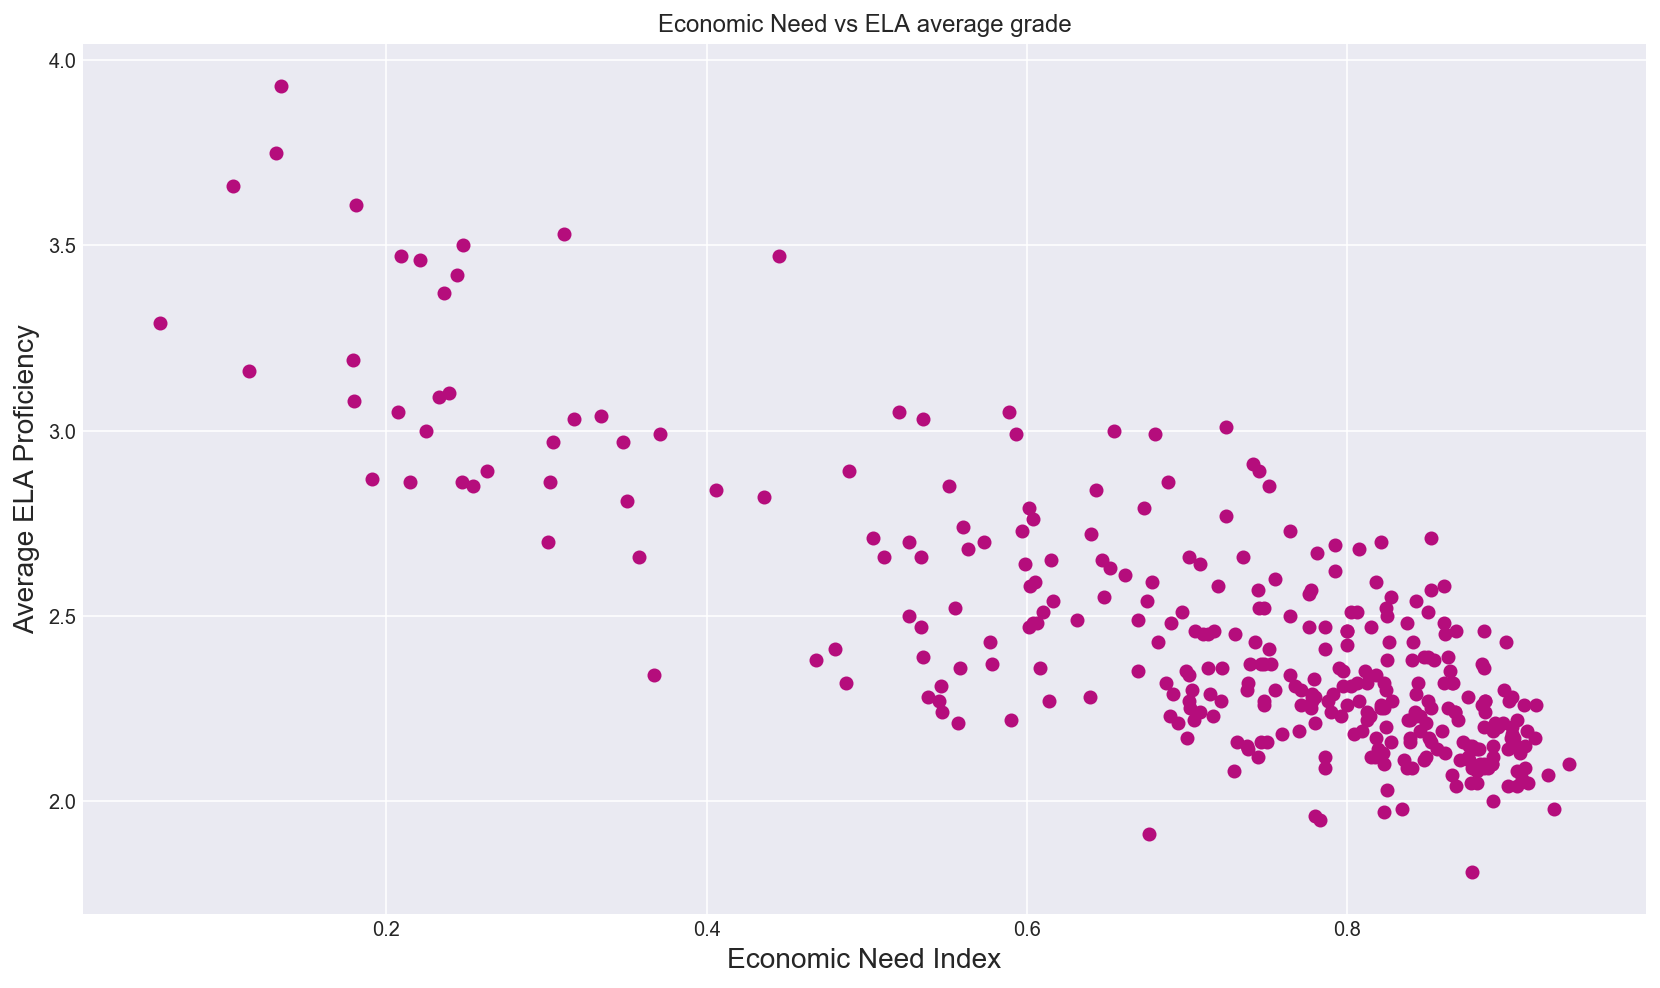

In [11]:
plt.figure(figsize=(14,8))
plt.scatter(df1['Economic Need Index'], df1['Average ELA Proficiency'], color='#b50d7c')

plt.title('Economic Need vs ELA average grade')
plt.xlabel("Economic Need Index", fontsize=14)
plt.ylabel("Average ELA Proficiency", fontsize=14)
plt.savefig("1Economic_need.png", bbox_inches='tight')
plt.show()

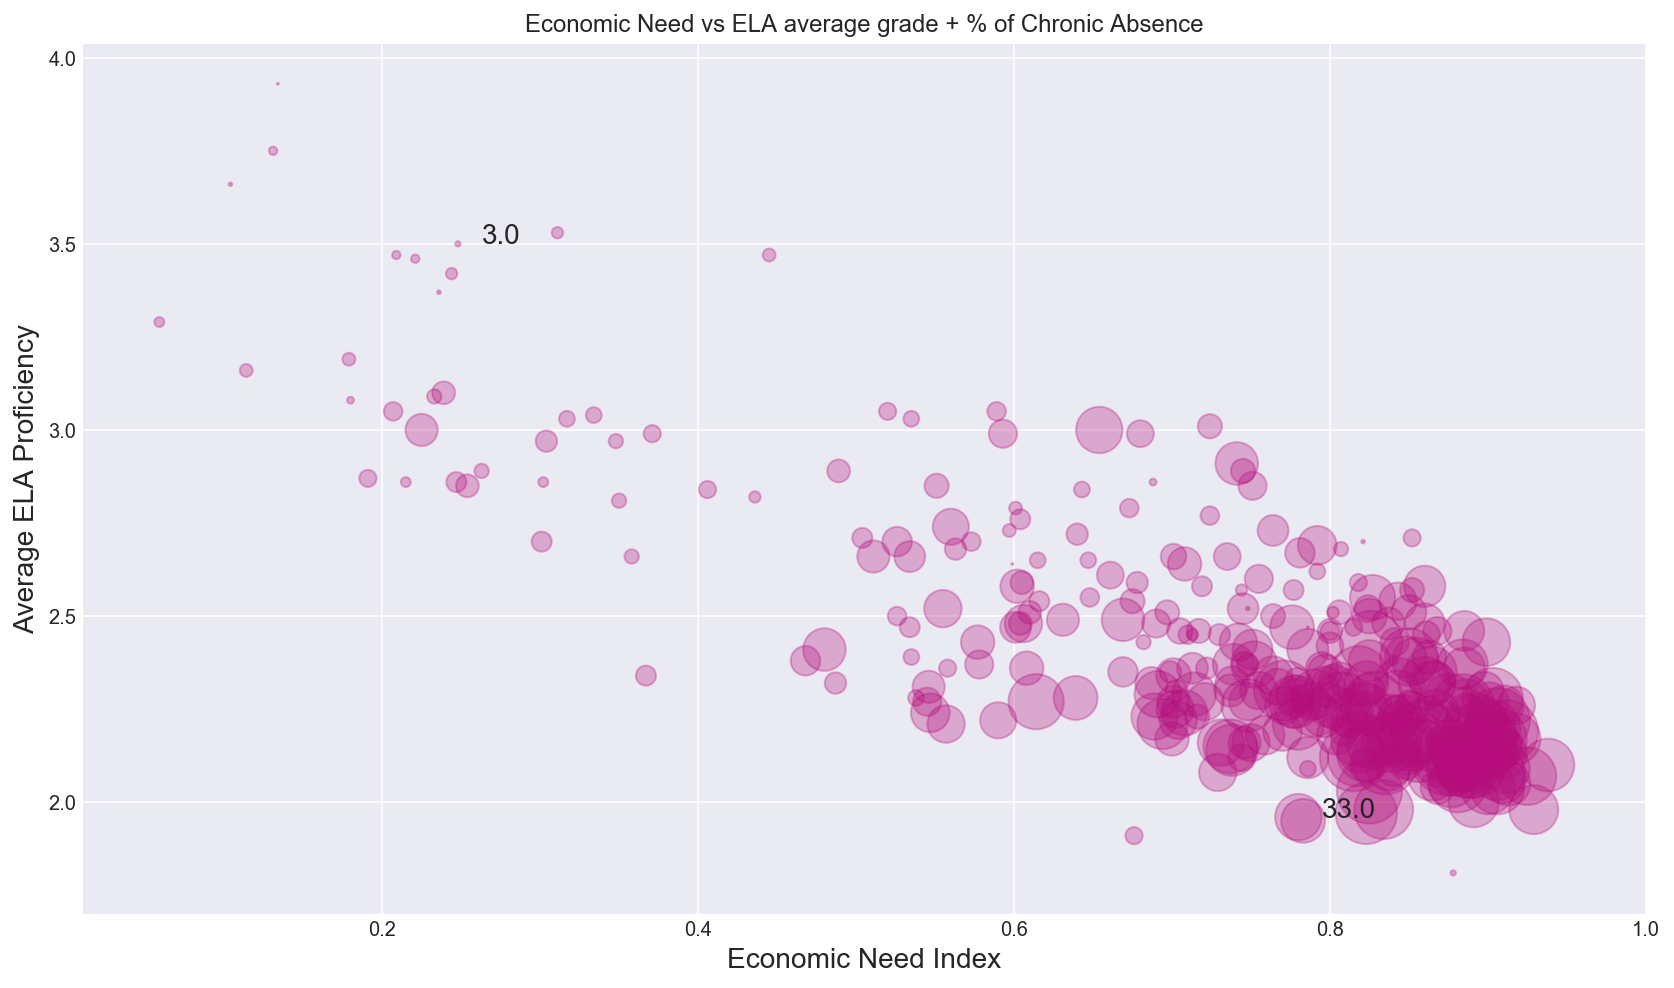

In [12]:
plt.figure(figsize=(14,8))
plt.scatter(df1['Economic Need Index'], df1['Average ELA Proficiency'], color='#b50d7c',
            s=df1['Percent of Students Chronically Absent']**1.8, alpha=0.3)

plt.title('Economic Need vs ELA average grade + % of Chronic Absence')
plt.xlabel("Economic Need Index", fontsize=14)
plt.ylabel("Average ELA Proficiency", fontsize=14)
#label marker
for idx, x in df1['Percent of Students Chronically Absent'][[266,1211]].iteritems():
    plt.annotate(x,(df1['Economic Need Index'][idx]+0.015,df1['Average ELA Proficiency'][idx]), 
                 fontsize=14)
plt.savefig("2Economic_need.png", bbox_inches='tight')
plt.show()

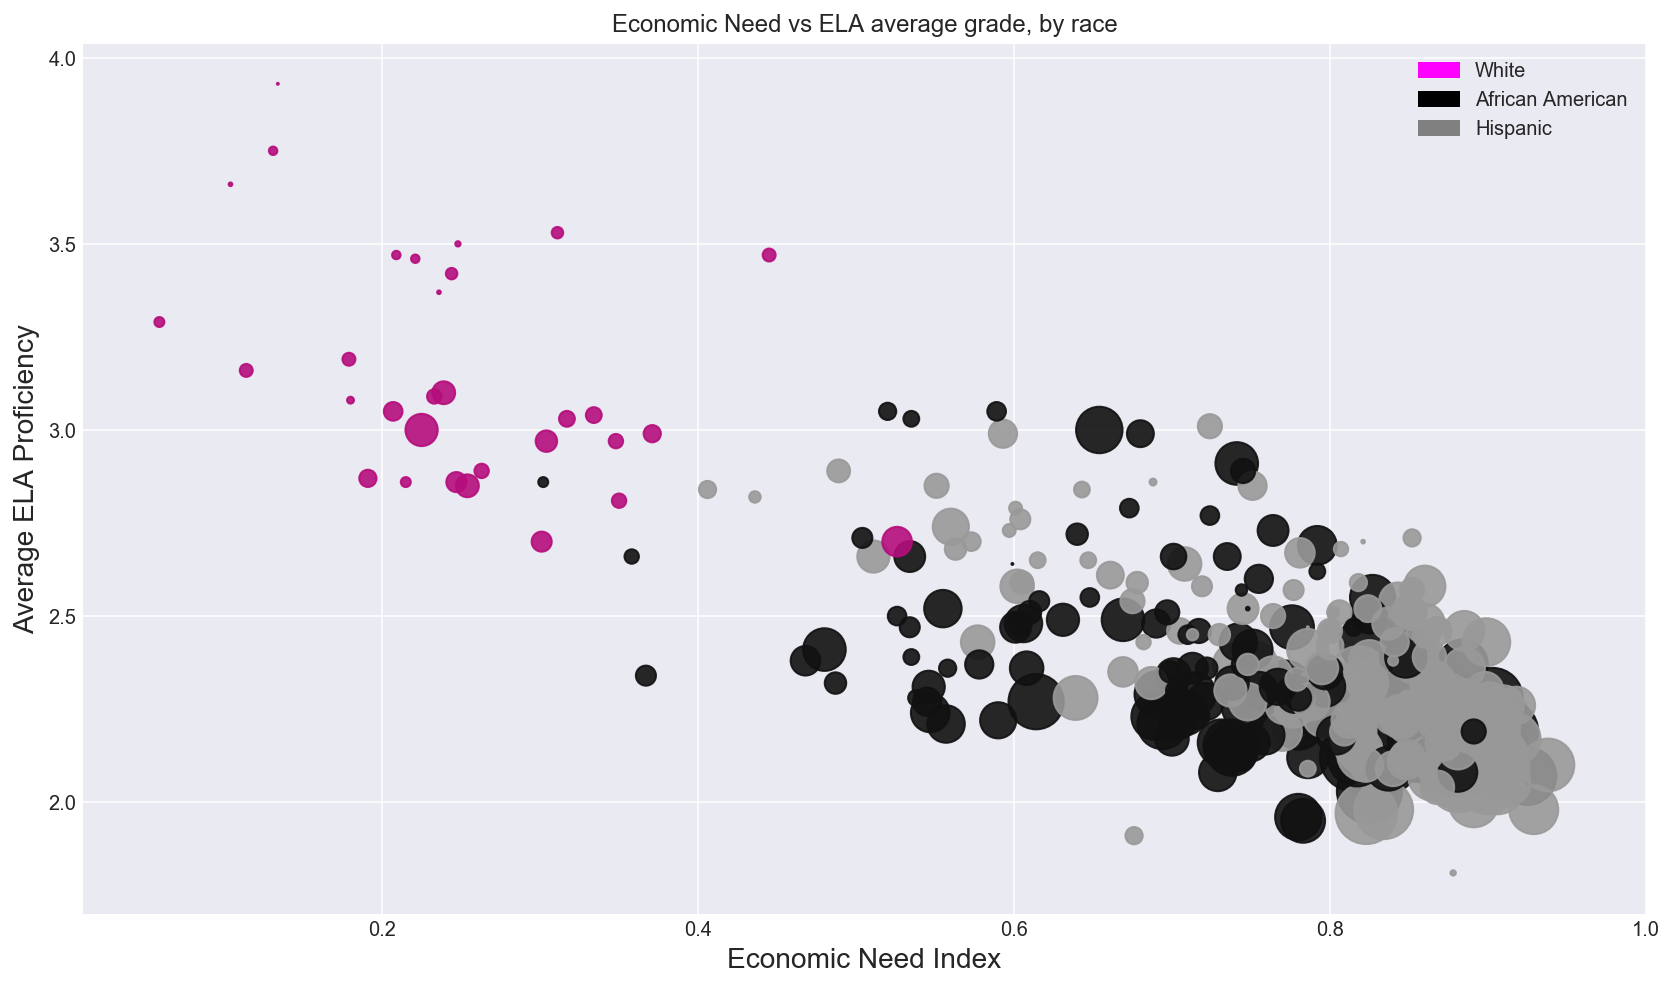

In [13]:
color= ['#111111' if x=='African American' else '#b50d7c' if x =='White' else '#999999' for x in df1['race']]

plt.figure(figsize=(14,8))
plt.scatter(df1['Economic Need Index'], df1['Average ELA Proficiency'], 
        color=color, s=df1['Percent of Students Chronically Absent']**1.8,alpha=0.9)

plt.title('Economic Need vs ELA average grade, by race')
plt.xlabel("Economic Need Index", fontsize=14)
plt.ylabel("Average ELA Proficiency", fontsize=14)   

# create labels and legend manually
import matplotlib.patches as mpatches
magenta_patch = mpatches.Patch(color='magenta', label='White')
black_patch = mpatches.Patch(color='black', label='African American')
gray_patch = mpatches.Patch(color='gray', label='Hispanic')
plt.legend(handles=[magenta_patch, black_patch, gray_patch])

plt.savefig("3Economic_need.png", bbox_inches='tight')
plt.show()

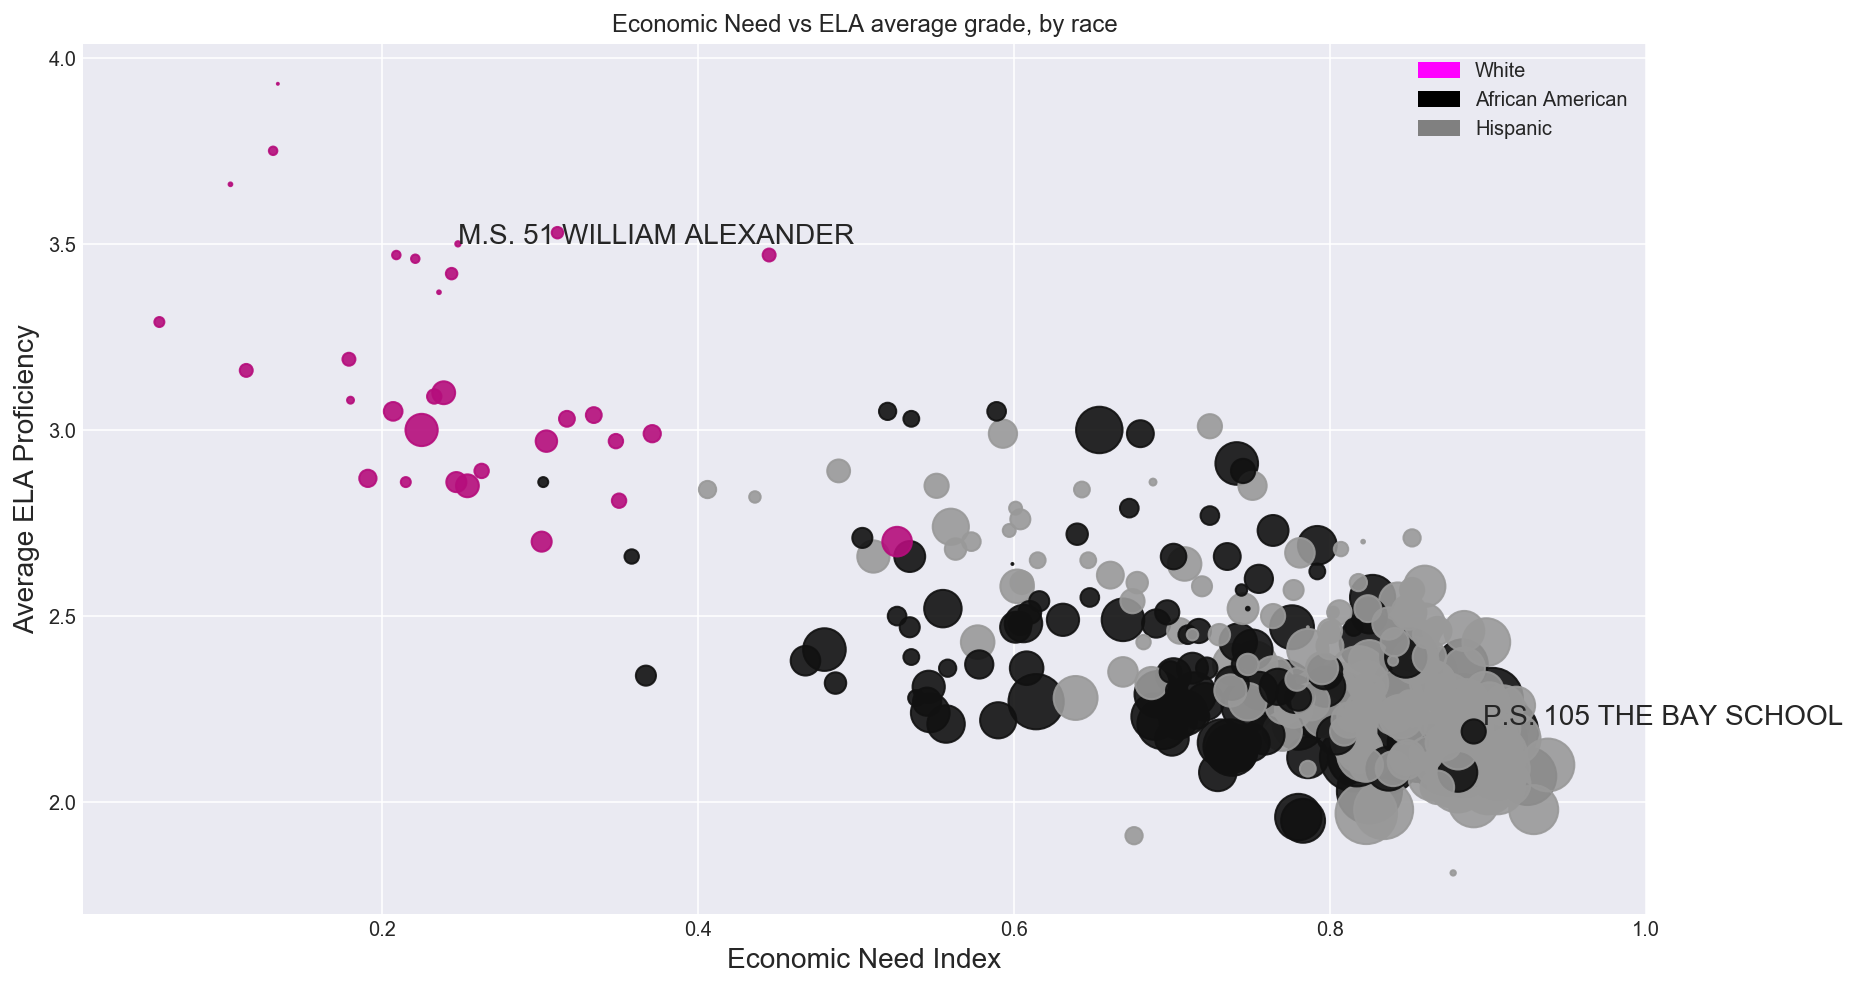

In [14]:
color= ['#111111' if x=='African American' else '#b50d7c' if x =='White' else '#999999' for x in df1['race']]

plt.figure(figsize=(14,8))
plt.scatter(df1['Economic Need Index'], df1['Average ELA Proficiency'], 
            color=color, s=df1['Percent of Students Chronically Absent']**1.8,alpha=0.9)

plt.title('Economic Need vs ELA average grade, by race')
plt.xlabel("Economic Need Index", fontsize=14)
plt.ylabel("Average ELA Proficiency", fontsize=14)
#label marker
for idx, x in df1['School Name'][[171,1211]].iteritems():
    plt.annotate(x,(df1['Economic Need Index'][idx],df1['Average ELA Proficiency'][idx]), 
                 fontsize=14)
    
    
# create labels and legend manually
import matplotlib.patches as mpatches
magenta_patch = mpatches.Patch(color='magenta', label='White')
black_patch = mpatches.Patch(color='black', label='African American')
gray_patch = mpatches.Patch(color='gray', label='Hispanic')
plt.legend(handles=[magenta_patch, black_patch, gray_patch])

plt.savefig("4Economic_need.png", bbox_inches='tight')
plt.show()

# Other Characteristics of Segregation in Education

In [15]:
# Remove hispanic children from race
df1 = df1[(df1['Percent Black']>50) | (df1['Percent White']>50)]

**Supportive Environment Rating:**

How well the school establishes a culture where **students feel safe, challenged to grow, and supported to meet high expectations**

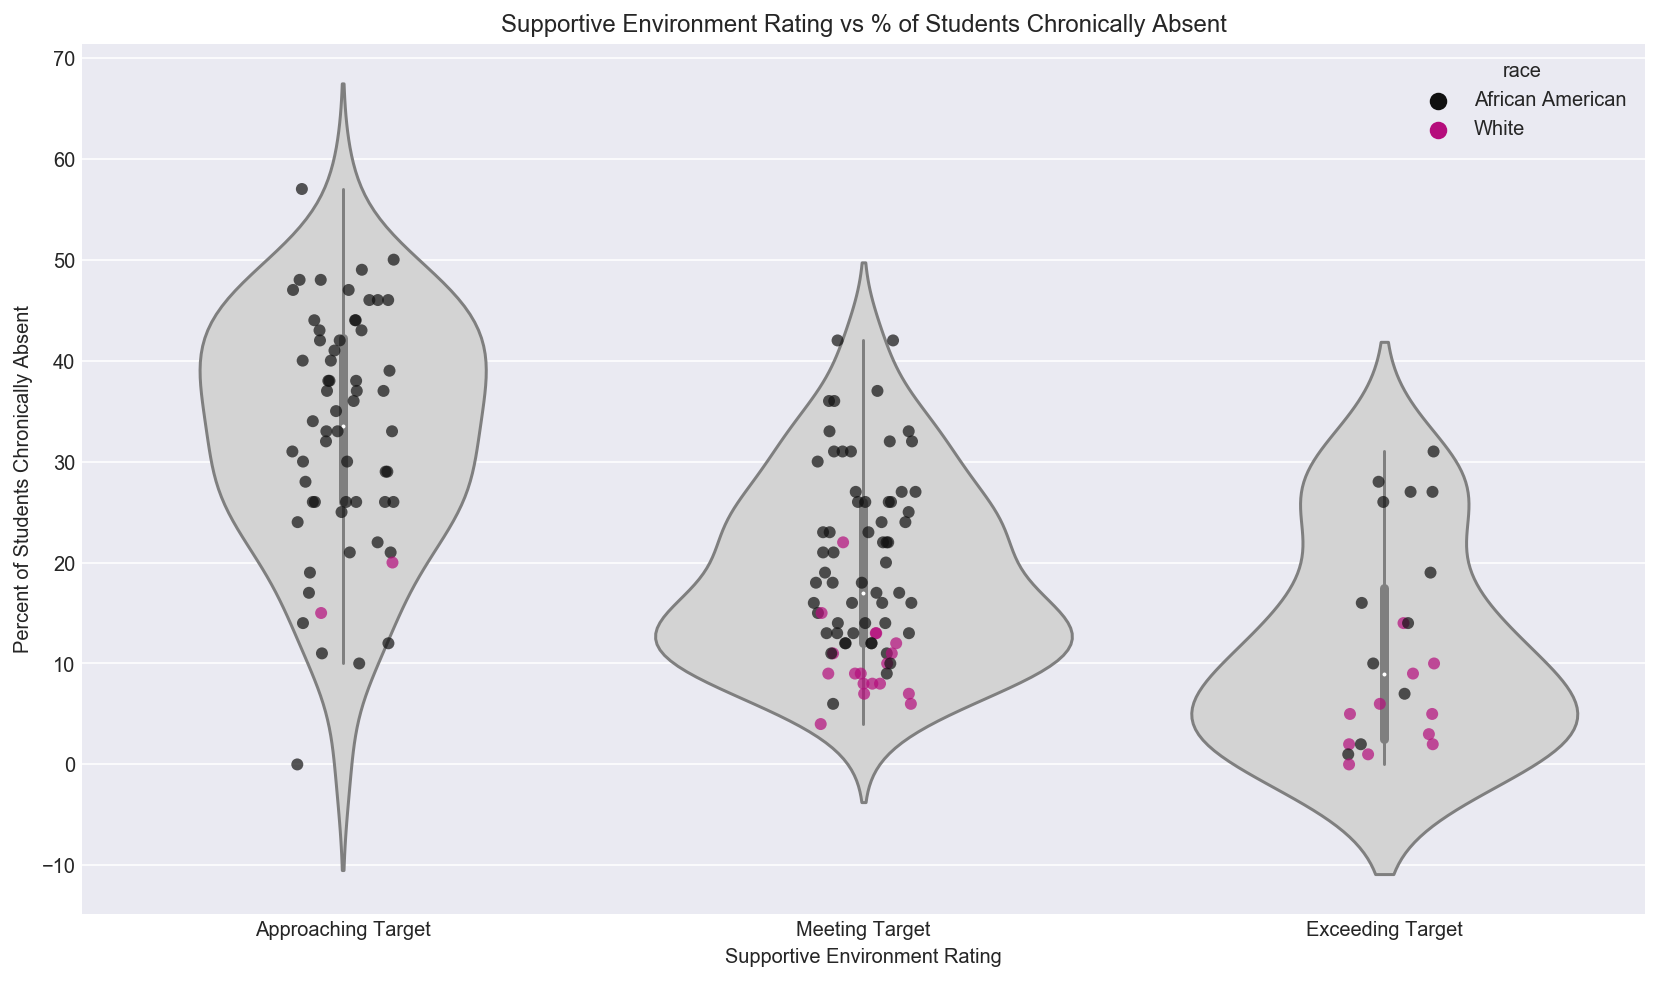

In [16]:
sns.violinplot(x='Supportive Environment Rating', y='Percent of Students Chronically Absent', data=df1, 
               inner='box', color='lightgray')

sns.stripplot(x='Supportive Environment Rating', y='Percent of Students Chronically Absent', data=df1, 
              jitter=True, hue='race', 
              palette=sns.color_palette(["#111111","#b50d7c"]), size=6, alpha=0.7)

plt.xticks(rotation='horizontal')
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.title("Supportive Environment Rating vs % of Students Chronically Absent")
plt.savefig("SupportiveEnvironment.png", bbox_inches='tight')
plt.show()

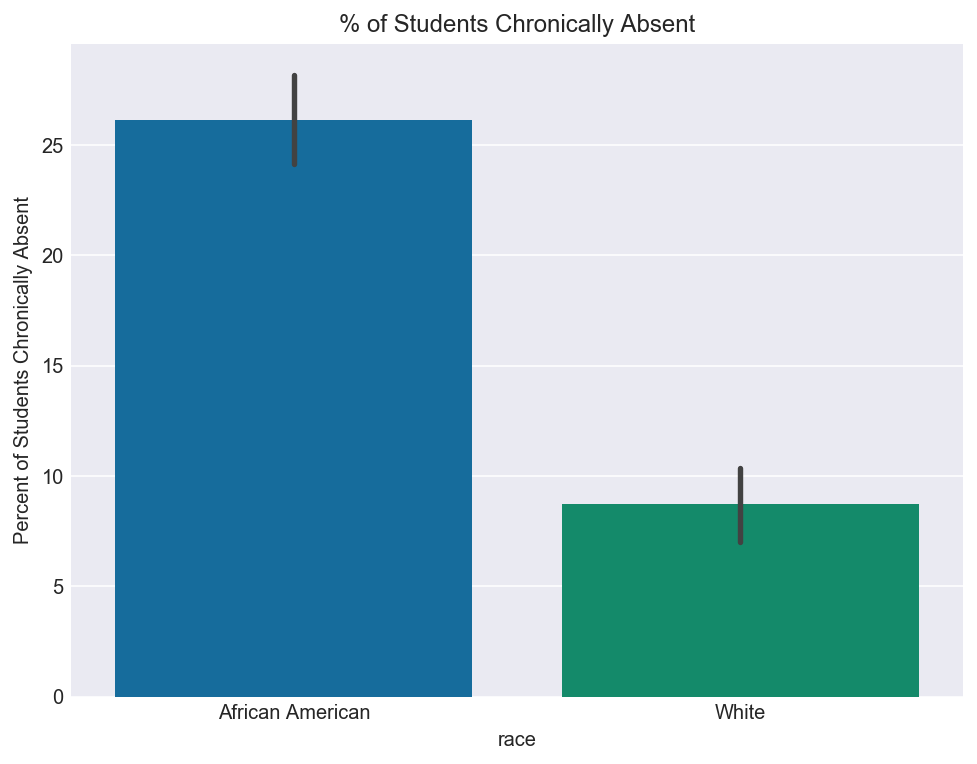

In [17]:
sns.barplot(x='race', y='Percent of Students Chronically Absent', data=df1)
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.title("% of Students Chronically Absent")
plt.savefig("Percnt_Chronically_Absent.png", bbox_inches='tight')
plt.show()

**Trust Rating:**
    
Whether the relationships between administrators, educators, students, and families are based on trust and respect   

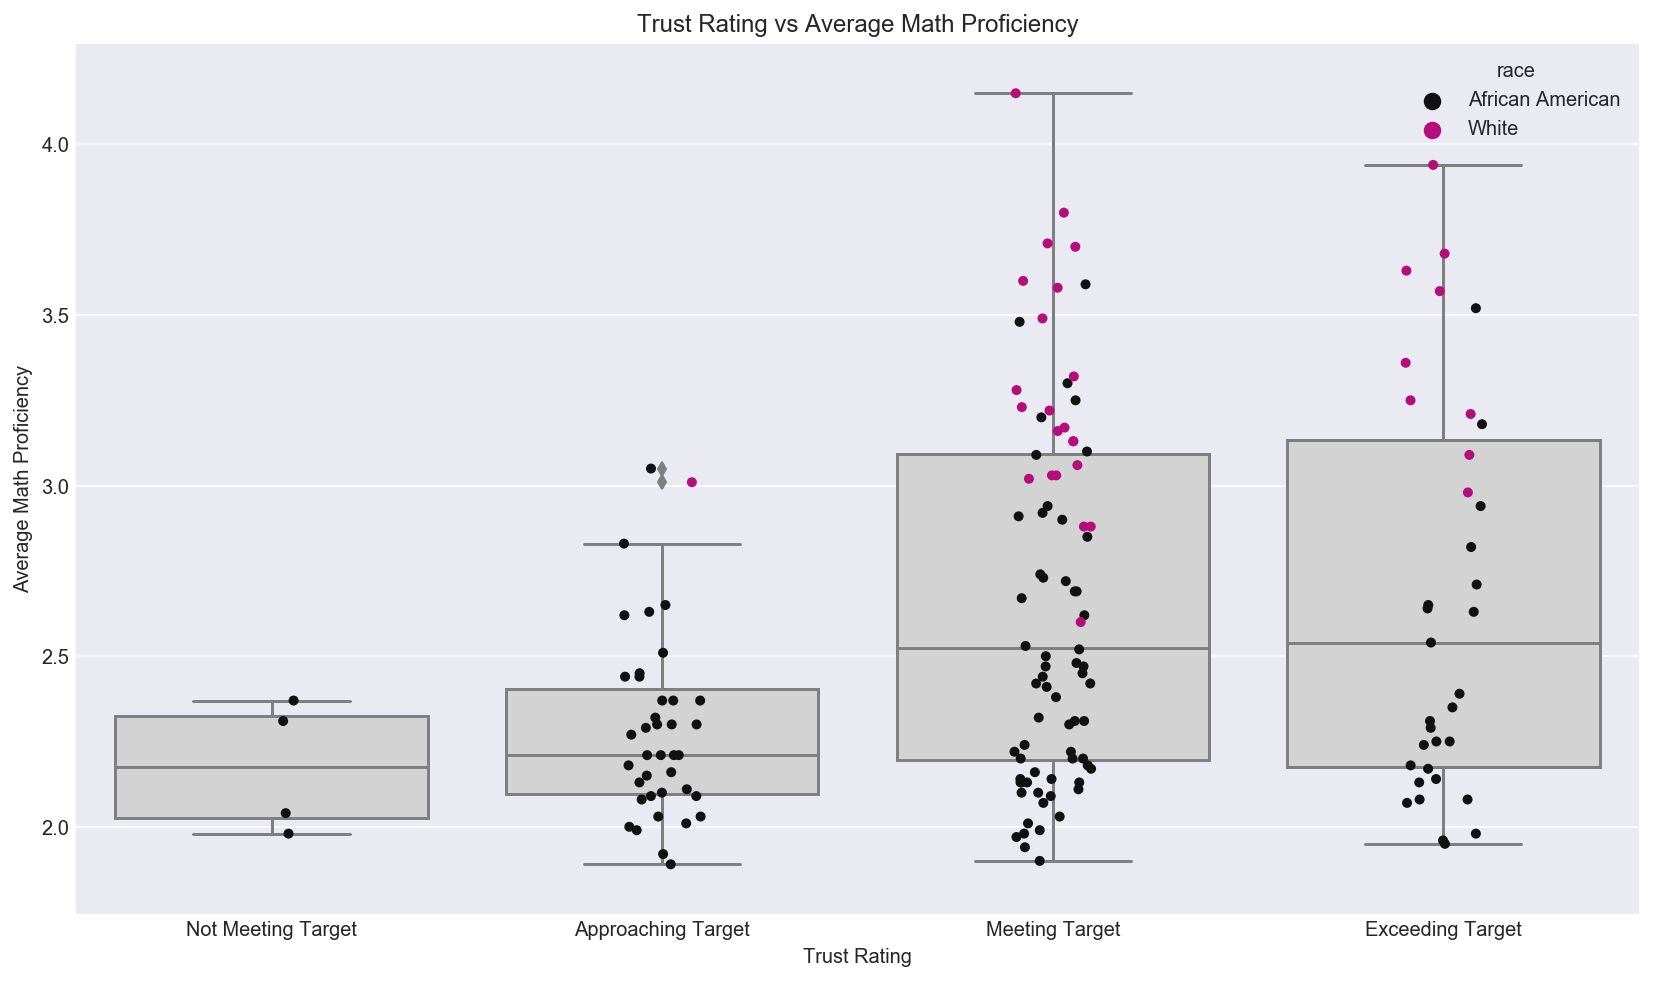

In [18]:
sns.boxplot(x='Trust Rating', y='Average Math Proficiency', data=df1, color='lightgray', order=['Not Meeting Target',
                                                      'Approaching Target',
                                                      'Meeting Target',
                                                      'Exceeding Target'])


sns.stripplot(x='Trust Rating', y='Average Math Proficiency', data=df1, jitter=True, size=5, hue='race', 
              palette=sns.color_palette(["#111111","#b50d7c"]), alpha=1, order=['Not Meeting Target',
                                                                                  'Approaching Target',
                                                                                  'Meeting Target',
                                                                                  'Exceeding Target'])
plt.xticks(rotation='horizontal')
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.title("Trust Rating vs Average Math Proficiency")
plt.savefig("Trust_Rating.png", bbox_inches='tight')
plt.show()

**Effective School Leadership Rating:**

How well school leadership inspires the school community with a **clear instructional vision** and effectively distributes leadership to realize this vision

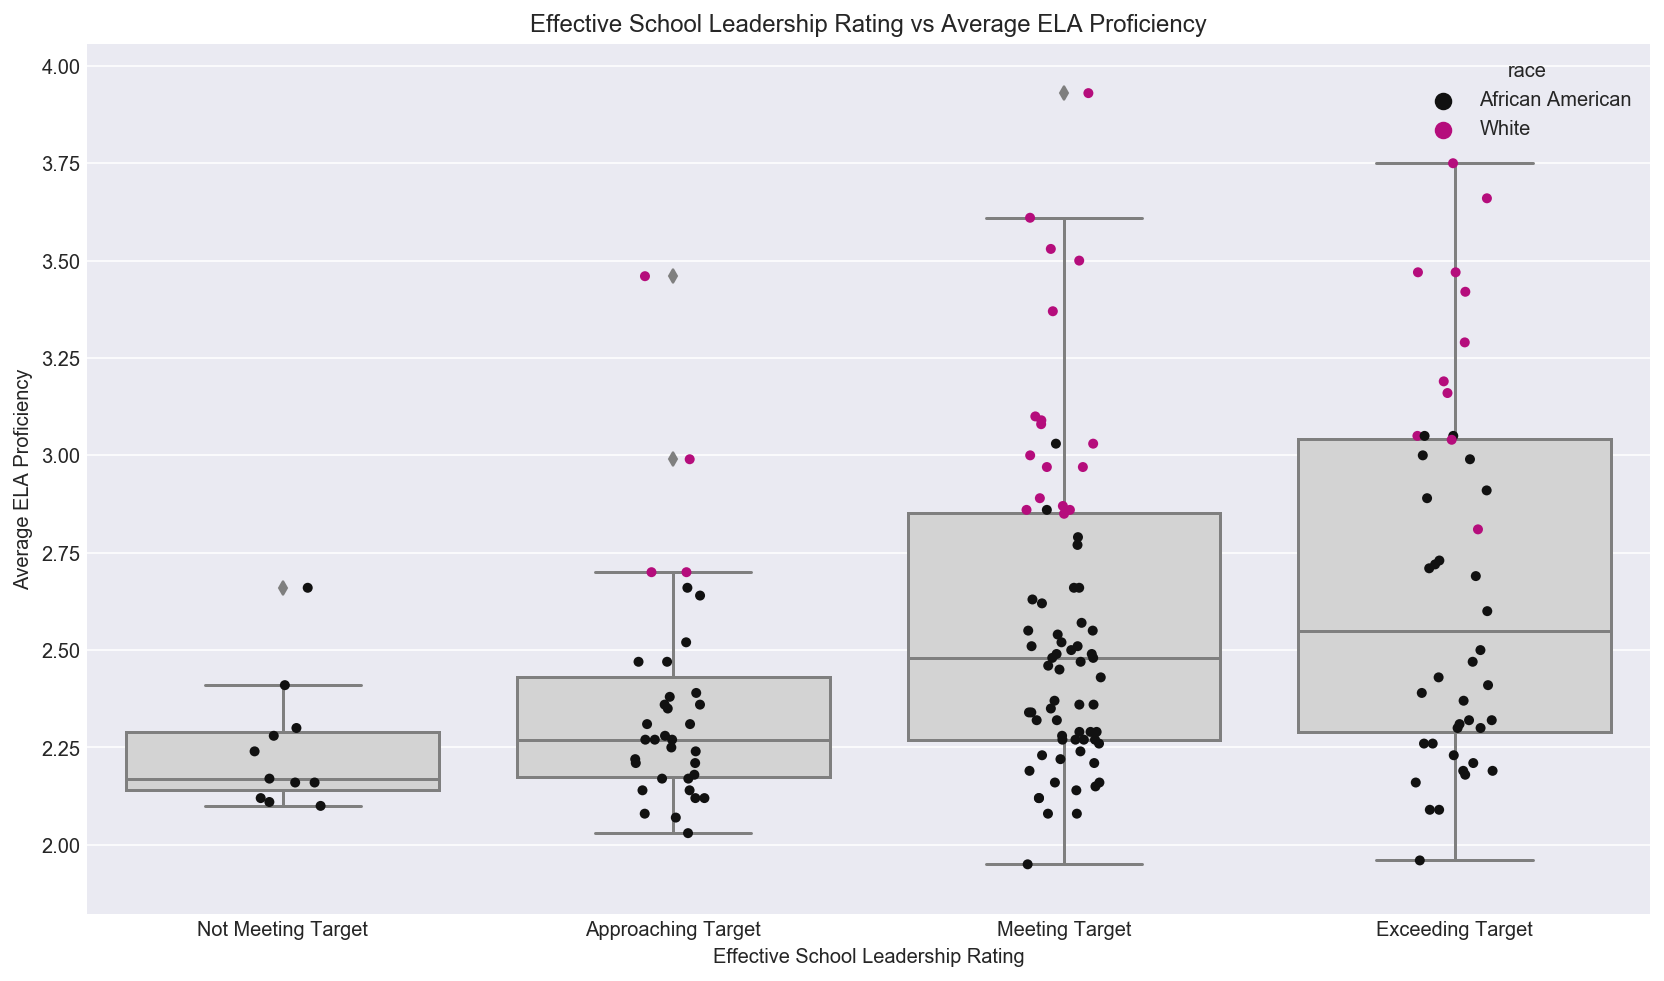

In [19]:
sns.boxplot(x='Effective School Leadership Rating', y='Average ELA Proficiency', data=df1, 
            color='lightgray', order=['Not Meeting Target',
                                        'Approaching Target',
                                        'Meeting Target',
                                        'Exceeding Target'])

sns.stripplot(x='Effective School Leadership Rating', y='Average ELA Proficiency', data=df1, jitter=True, size=5, hue='race', 
              palette=sns.color_palette(["#111111","#b50d7c"]), order=['Not Meeting Target',
                                                                                  'Approaching Target',
                                                                                  'Meeting Target',
                                                                                  'Exceeding Target'])
plt.xticks(rotation='horizontal')
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.title("Effective School Leadership Rating vs Average ELA Proficiency")
plt.savefig("Effective_School_Leadership.png", bbox_inches='tight')
plt.show()

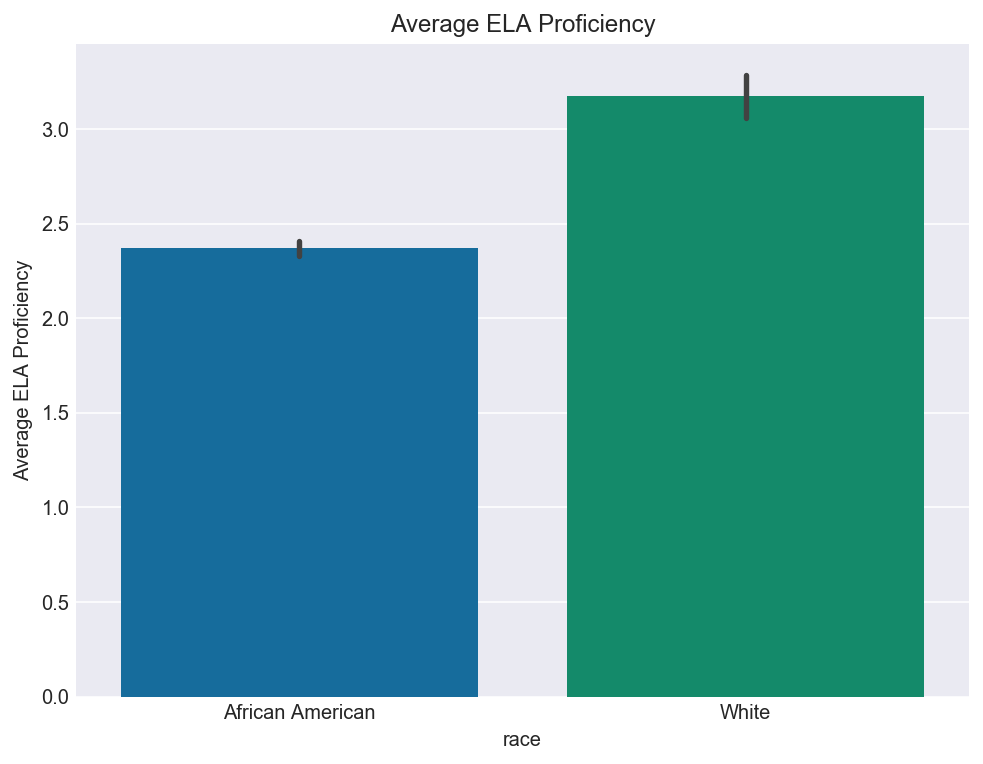

In [20]:
sns.barplot(x='race', y='Average ELA Proficiency', data=df1)
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.title("Average ELA Proficiency")
plt.savefig("ELA Proficiency.png", bbox_inches='tight')
plt.show()

# Bivariate Linear Regression

In [21]:
df2 = df.copy()
df2 = df2[['Grade High','Economic Need Index','School Income Estimate','Percent Black / Hispanic',
           'Percent White','Percent of Students Chronically Absent','Average ELA Proficiency',
           'Supportive Environment Rating', 'Effective School Leadership Rating','Trust Rating',
           'Student Achievement Rating','Percent Black','Percent Hispanic','Trust %',
           'Collaborative Teachers %','Average Math Proficiency','Supportive Environment %',
           'School Name','Effective School Leadership %']]

# convert data to floats
df2['Percent of Students Chronically Absent'] = df2['Percent of Students \
Chronically Absent'].str.rstrip('%').astype(float)
df2['Percent Black'] = df2['Percent Black'].str.rstrip('%').astype(float)
df2['Percent Hispanic'] = df2['Percent Hispanic'].str.rstrip('%').astype(float)
df2['Percent Black / Hispanic'] = df2['Percent Black / Hispanic'].str.rstrip('%').astype(float)

df2['Trust %'] = df2['Trust %'].str.rstrip('%').astype(float)
df2['Effective School Leadership %'] = df2['Effective School Leadership %'].str.rstrip('%').astype(float)
df2['Supportive Environment %'] = df2['Supportive Environment %'].str.rstrip('%').astype(float)
df2['Collaborative Teachers %'] = df2['Collaborative Teachers %'].str.rstrip('%').astype(float)
df2['Percent White'] = df2['Percent White'].str.rstrip('%').astype(float)
df2['School Income Estimate'] = df2['School Income Estimate'].str.strip('$')
df2['School Income Estimate'] = df2['School Income Estimate'].str.replace(",","").astype(float)

# drop the Null rows so there is no problems with the model later on
df2.dropna(subset=['Economic Need Index', 'Average Math Proficiency'],inplace=True)

# df2.info()

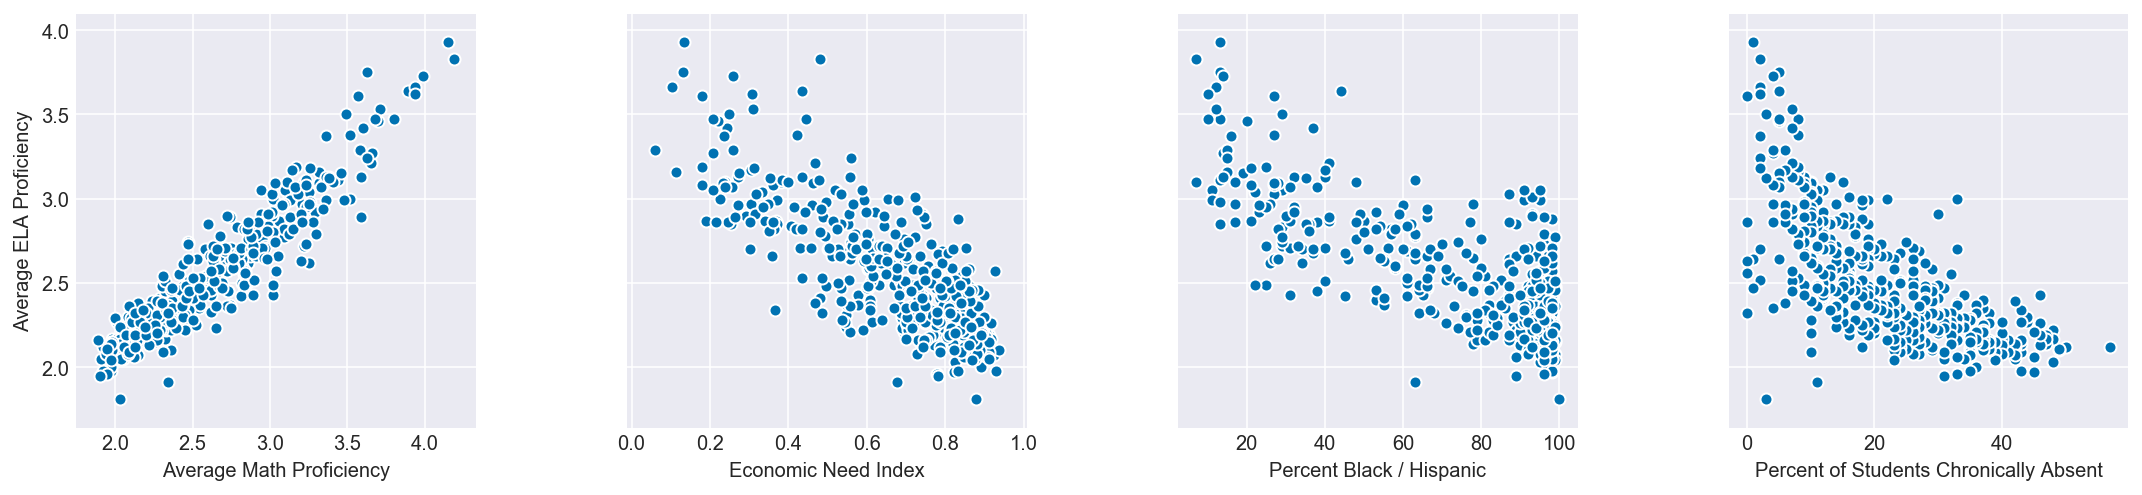

In [22]:
sns.pairplot(df2,x_vars=['Average Math Proficiency','Economic Need Index',
                         'Percent Black / Hispanic','Percent of Students Chronically Absent'],
             y_vars=["Average ELA Proficiency"])
fig=plt.gcf()
fig.set_size_inches(16,4)
plt.savefig("scatter of regressions")
plt.show()


In [23]:
df2[['Average Math Proficiency','Economic Need Index','Percent Black / Hispanic',
     'Percent of Students Chronically Absent', 'Average ELA Proficiency']].corr().round(2).iloc[4:]


Average Math Proficiency  Economic Need Index  \
Average ELA Proficiency                      0.94                -0.81   

                         Percent Black / Hispanic  \
Average ELA Proficiency                     -0.77   

                         Percent of Students Chronically Absent  \
Average ELA Proficiency                                   -0.71   

                         Average ELA Proficiency  
Average ELA Proficiency                      1.0

**There appears to be several variables correlated with ELA proficiency (average English Language Arts grades on report cards). In the following section we'll use biverate linear regressions to compute which variable is the strongest predictor of proficiency in ELA.** 

# Average Chronic Absence from School as predictor of ELA Proficiency

**Definitions:**

**Percent of Students Chronically Absent** is defined by missing 10% of school days or 18 days+ per year.

In [102]:
# Sort predictor for plotting purposes later on
df2.sort_values('Percent of Students Chronically Absent', inplace=True)

\begin{aligned}
ELA_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β*Absnt_i\\
α &\sim Normal(0,5)\\
β &\sim Normal(0,10)\\
σ &\sim Uniform(0,10)
\end{aligned}

We shall standardize the predictor because it is good practice and because it will help us compare slopes between predictors.

In [103]:
df2['stdized_absence']=(df2['Percent of Students Chronically Absent']-df2['Percent of Students \
Chronically Absent'].mean())/np.std(df2['Percent of Students Chronically Absent'])

In [104]:
with pm.Model() as r_1:
    α = pm.Normal('α', 0, 5)
    β = pm.Normal('β', 0, 10)
    σ = pm.Uniform('σ', 0, 10)
    μ = pm.Deterministic('μ', α + β * df2['stdized_absence'])
    
    ela_prof = pm.Normal('ela_prof', mu=μ, sd=σ, observed=df2['Average ELA Proficiency'])
    trace_r_1 = pm.sample(5000, tune=3000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, β, α]
100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1047.73it/s]


In [78]:
pm.summary(trace_r_1).head().round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
α     0.00  0.03       0.0    -0.07      0.07  14060.47   1.0
β    -0.71  0.03       0.0    -0.77     -0.64  16195.92   1.0
σ     0.71  0.02       0.0     0.66      0.75  13300.80   1.0
μ__0  1.26  0.07       0.0     1.12      1.39  15255.75   1.0
μ__1  1.26  0.07       0.0     1.12      1.39  15255.75   1.0

In [79]:
trace_r_1['μ'].mean()

0.0003610604996954643

Summary:
* β- for every 1 standard deviation increase in "Percent of Students Chronically Absent" , the school is expected to see a ecrease in its average ELA proficiency of 0.26.  
* μ- the average mean of all "Average ELA proficiencies" is 2.51
* σ- 95% of plausible "Average ELA proficiencies" lie within 0.52 (2σ) of the mean, that is, 2.51+-0.52
* α- given that we standardized the "Chronic Absent" variable, its mean is the same as the mean of "Average ELA proficiencies".

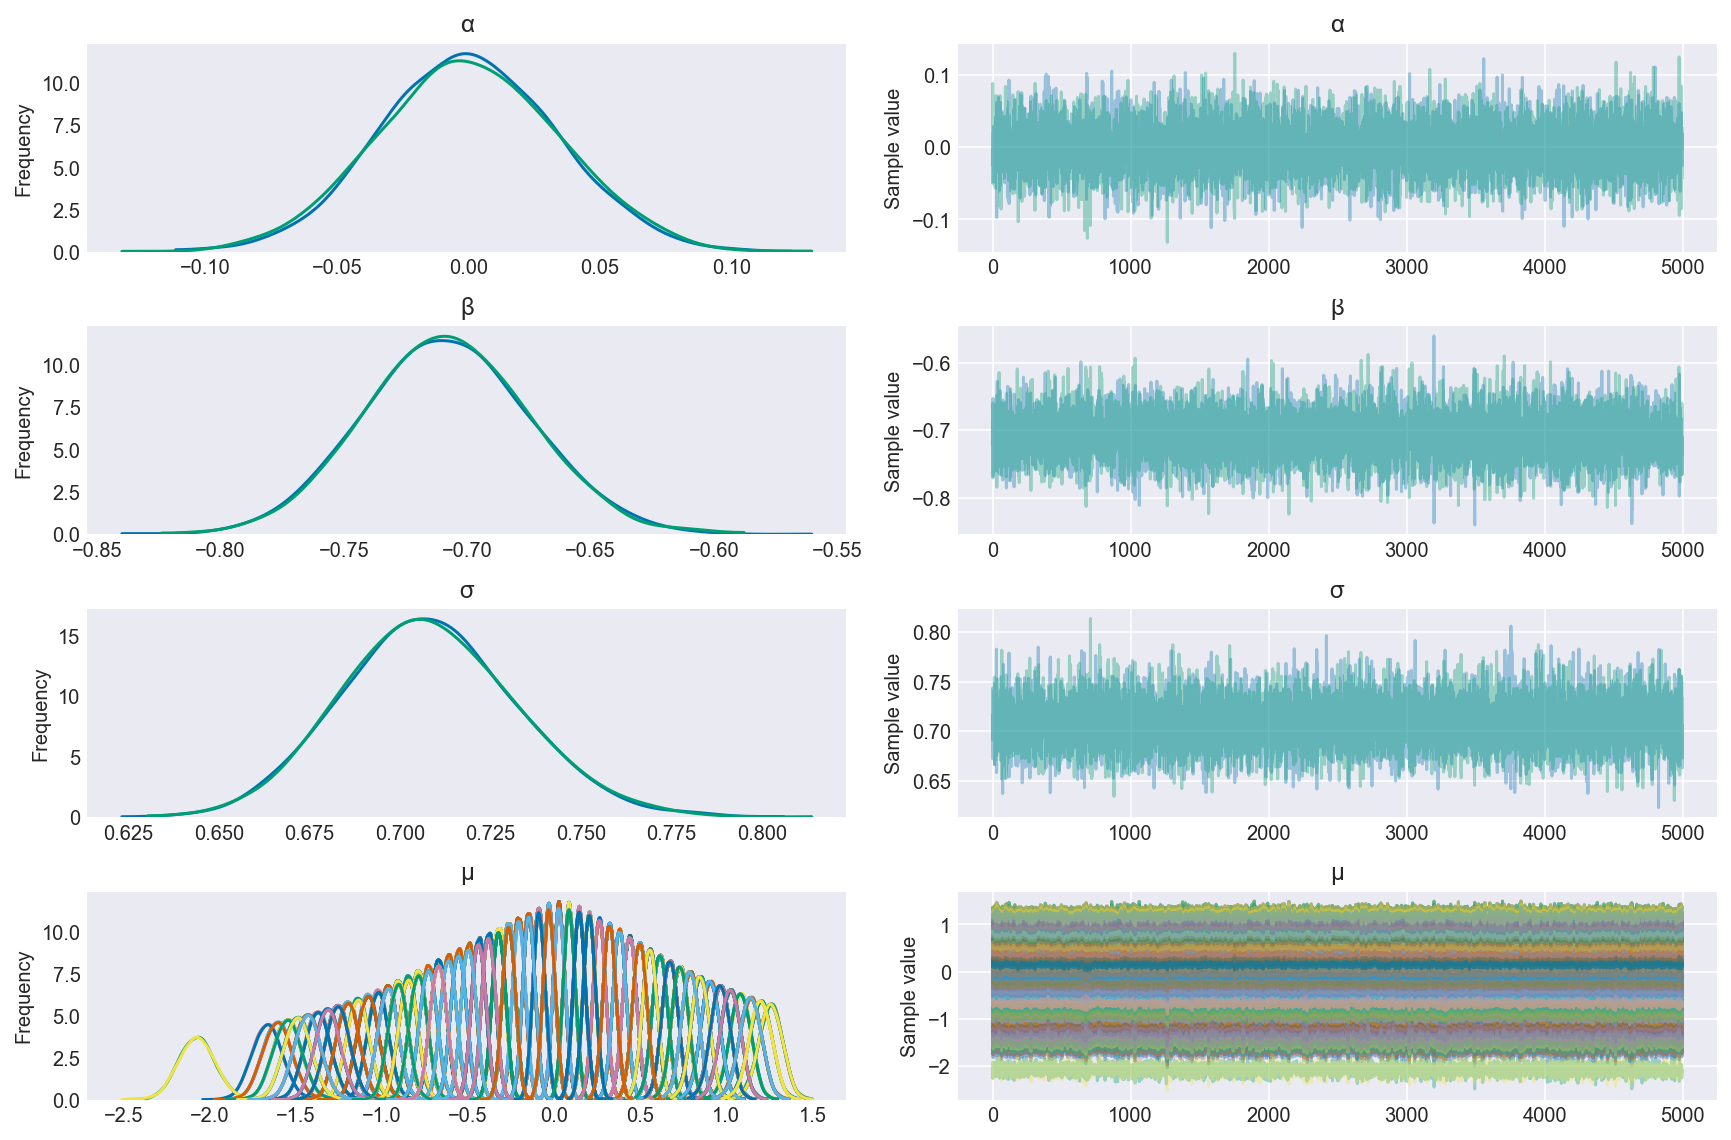

In [71]:
pm.traceplot(trace_r_1);

In [105]:
# 97% HPDI for the mean
mean_97_r1 = pm.hpd(trace_r_1['μ'], alpha=0.03)

# 97% HPDI for predicted Average ELA Proficiencies
pred_ELA_r1 = pm.sample_ppc(trace_r_1, 300, r_1) 
pred_ELA_97_r1 = pm.hpd(pred_ELA_r1['ela_prof'], alpha=0.03)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 834.57it/s]


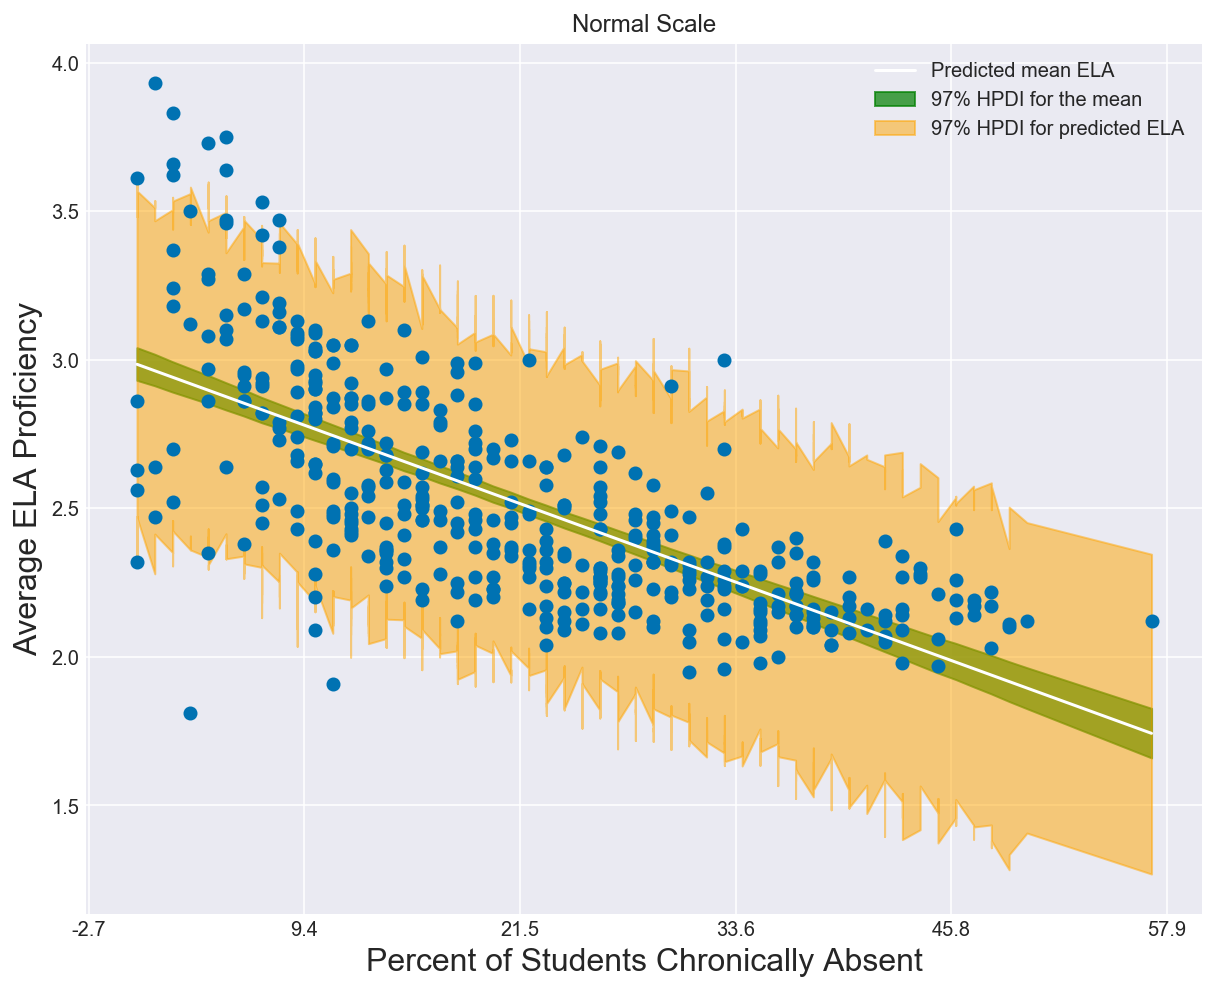

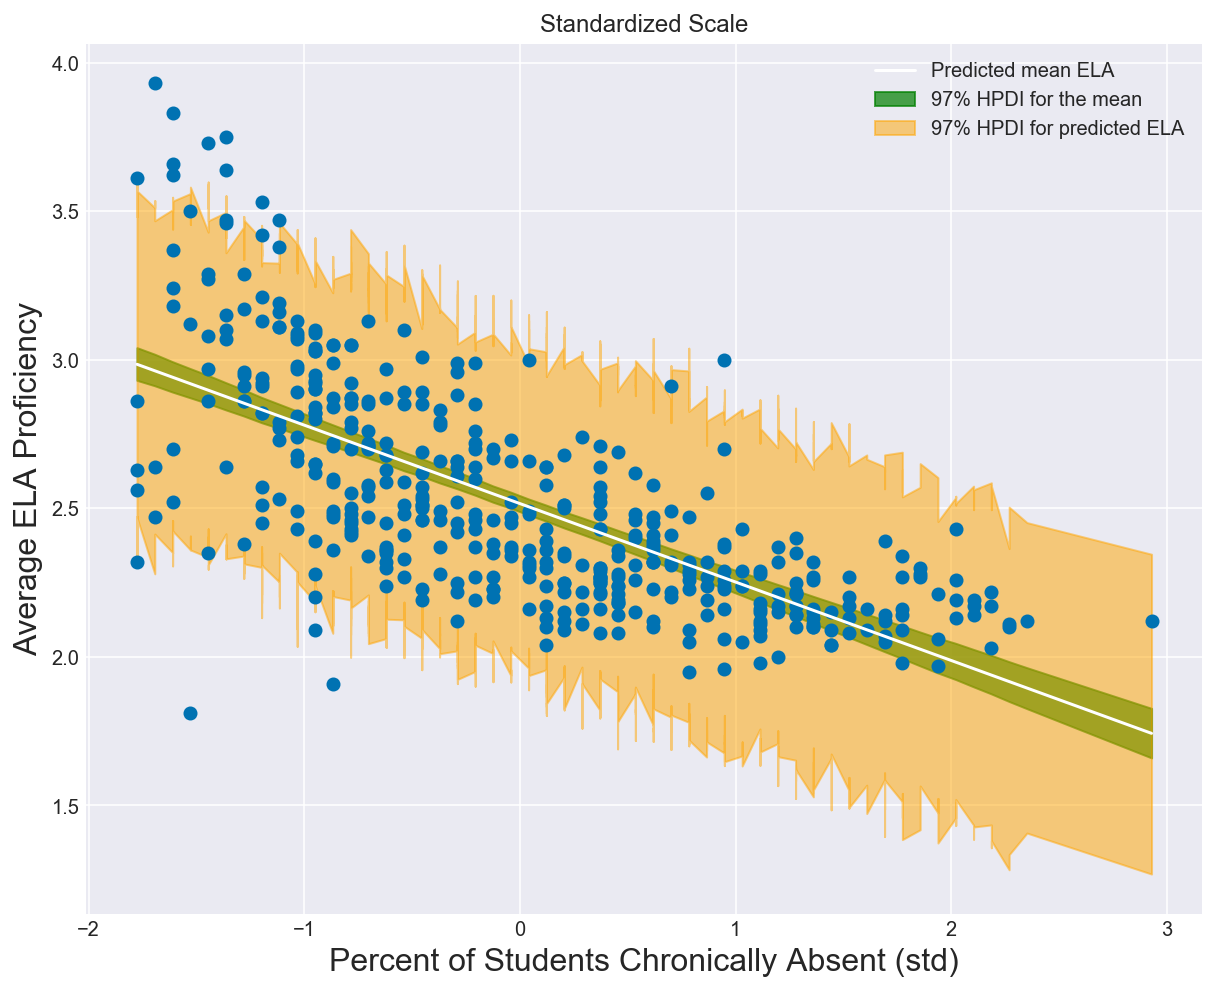

In [106]:
plt.figure(figsize=(10,8))

# plot the Chronic absences vs. ELA proficiencies
plt.plot(df2['stdized_absence'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of absences (this is the regression line)
plt.plot(df2['stdized_absence'], trace_r_1['α'].mean() + trace_r_1['β'].mean() * 
         df2['stdized_absence'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_absence'], mean_97_r1[:,0], mean_97_r1[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_absence'], pred_ELA_97_r1[:,0], pred_ELA_97_r1[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Normal Scale")
plt.xlabel("Percent of Students Chronically Absent", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()


#convert back to natural scale.
at = np.arange(-2,4)
plt.xticks(at, np.round(at * df2['Percent of Students Chronically Absent'].std() + 
                        df2['Percent of Students Chronically Absent'].mean(), 1));

plt.show()
plt.close()


plt.figure(figsize=(10,8))

# plot the Chronic absences vs. ELA proficiencies
plt.plot(df2['stdized_absence'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of absences (this is the regression line)
plt.plot(df2['stdized_absence'], trace_r_1['α'].mean() + trace_r_1['β'].mean() * 
         df2['stdized_absence'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_absence'], mean_97_r1[:,0], mean_97_r1[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_absence'], pred_ELA_97_r1[:,0], pred_ELA_97_r1[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Percent of Students Chronically Absent (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()

plt.show()

In [82]:
df_trace_r1 = pm.trace_to_dataframe(trace_r_1, varnames=['α','β','σ'])
df_trace_r1.corr().round(2)

α     β    σ
α  1.00  0.02  0.0
β  0.02  1.00  0.0
σ  0.00  0.00  1.0

Given that we standardized the predictor, there is no correlation between the parameters. This will come in handy in more complex models.

# Percent Black/Hispanic as predictor of ELA Proficiency
**Definition:**

**Percent Black/Hispanic** is the percent of students that are either African American or Hispanic in each school

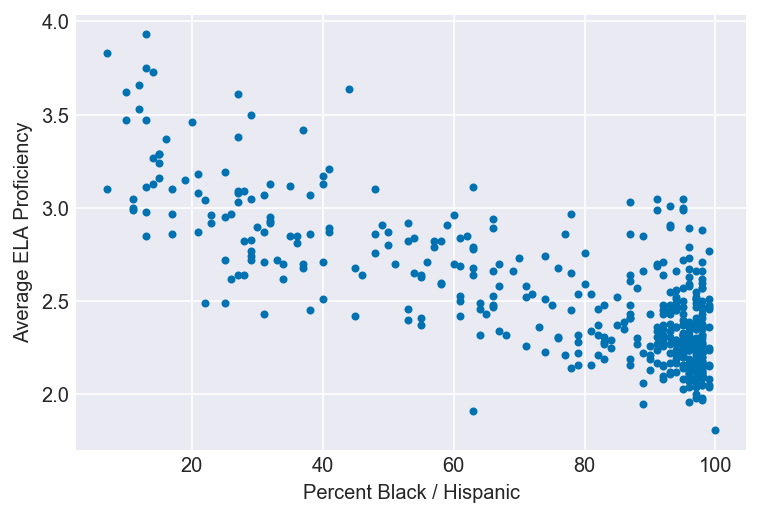

In [95]:
plt.plot(df2['Percent Black / Hispanic'],df2['Average ELA Proficiency'],  '.')
plt.xlabel("Percent Black / Hispanic")
plt.ylabel("Average ELA Proficiency");

In [96]:
# Sort predictor for plotting purposes later on
df2.sort_values('Percent Black / Hispanic', inplace=True)

In [97]:
# Standardize the predictor
df2['stdized_HispBlck']=(df2['Percent Black / Hispanic']-df2['Percent Black / Hispanic'].mean())/np.std(
    df2['Percent Black / Hispanic'])

\begin{aligned}
ELA_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β*HispBlck_i\\
α &\sim Normal(2,5)\\
β &\sim Normal(0,2)\\
σ &\sim Uniform(0,5)
\end{aligned}

In [98]:
with pm.Model() as r_2:
    α = pm.Normal('α', 2, 5)
    β = pm.Normal('β', 0, 2)
    σ = pm.Uniform('σ', 0, 5)
    μ = pm.Deterministic('μ', α + β * df2['stdized_HispBlck'])
    
    ela_prof = pm.Normal('ela_prof', mu=μ, sd=σ, observed=df2['Average ELA Proficiency'])
    trace_r_2 = pm.sample(5000, tune=3000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, β, α]
100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:08<00:00, 993.56it/s]


In [99]:
pm.summary(trace_r_2).head().round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
α     2.52  0.01       0.0     2.49      2.54  14731.30   1.0
β    -0.29  0.01       0.0    -0.31     -0.27  14386.27   1.0
σ     0.24  0.01       0.0     0.22      0.25  15222.05   1.0
μ__0  3.22  0.03       0.0     3.17      3.29  14884.42   1.0
μ__1  3.22  0.03       0.0     3.17      3.29  14884.42   1.0

Summary:
* β- for every 1 standard deviation increase in "% Hispanic/Black" , the school is expected to see a decrease in its average ELA proficiency of 0.29.  
* μ- the average mean of all "Average ELA proficiencies" is 2.51
* σ- 95% of plausible "Average ELA proficiencies" lie within 0.48 (2σ) of the mean, that is, 2.51+-0.48
* α- given that we standardized the "% Hispanic/Black" variable, its mean is the same as the mean of "Average ELA proficiencies".

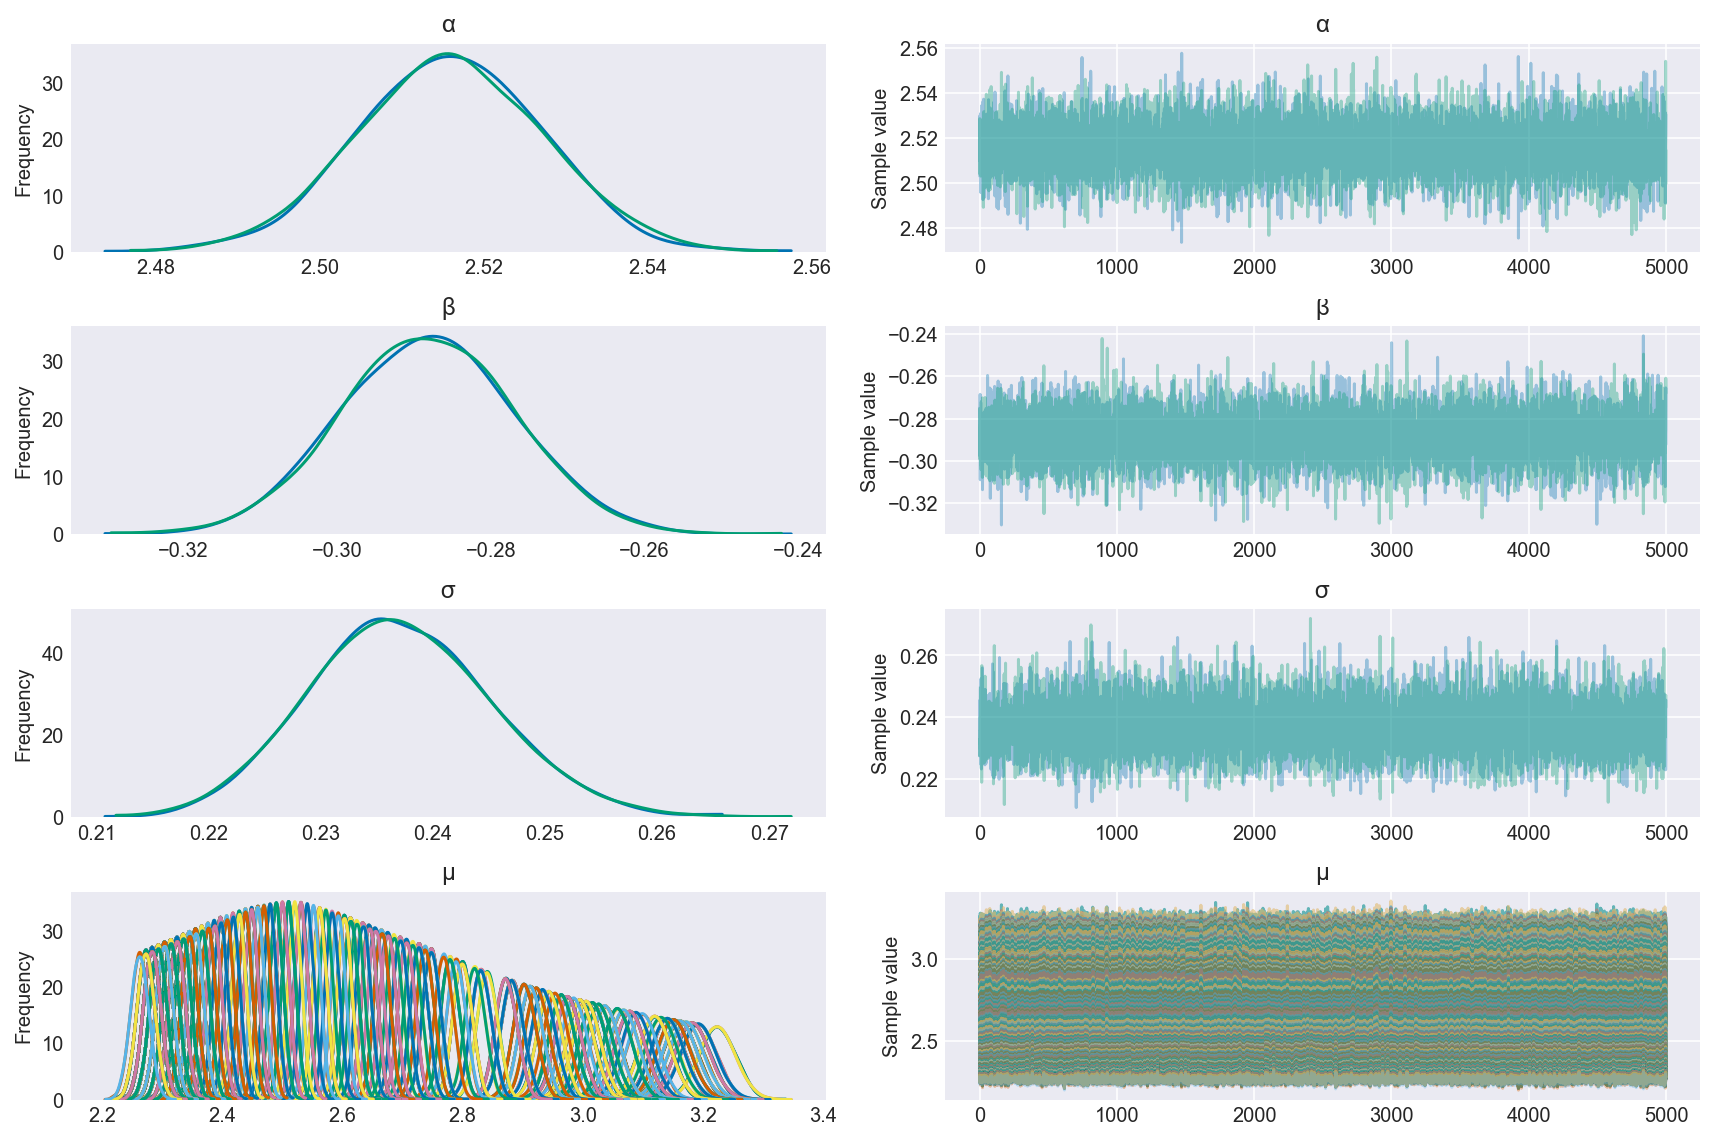

In [39]:
pm.traceplot(trace_r_2);

In [100]:
# 97% HPDI for the mean
mean_97_r2 = pm.hpd(trace_r_2['μ'], alpha=0.03)

# 97% HPDI for predicted Average ELA Proficiencies
pred_ELA_r2 = pm.sample_ppc(trace_r_2, 300, r_2) 
pred_ELA_97_r2 = pm.hpd(pred_ELA_r2['ela_prof'], alpha=0.03)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 834.10it/s]


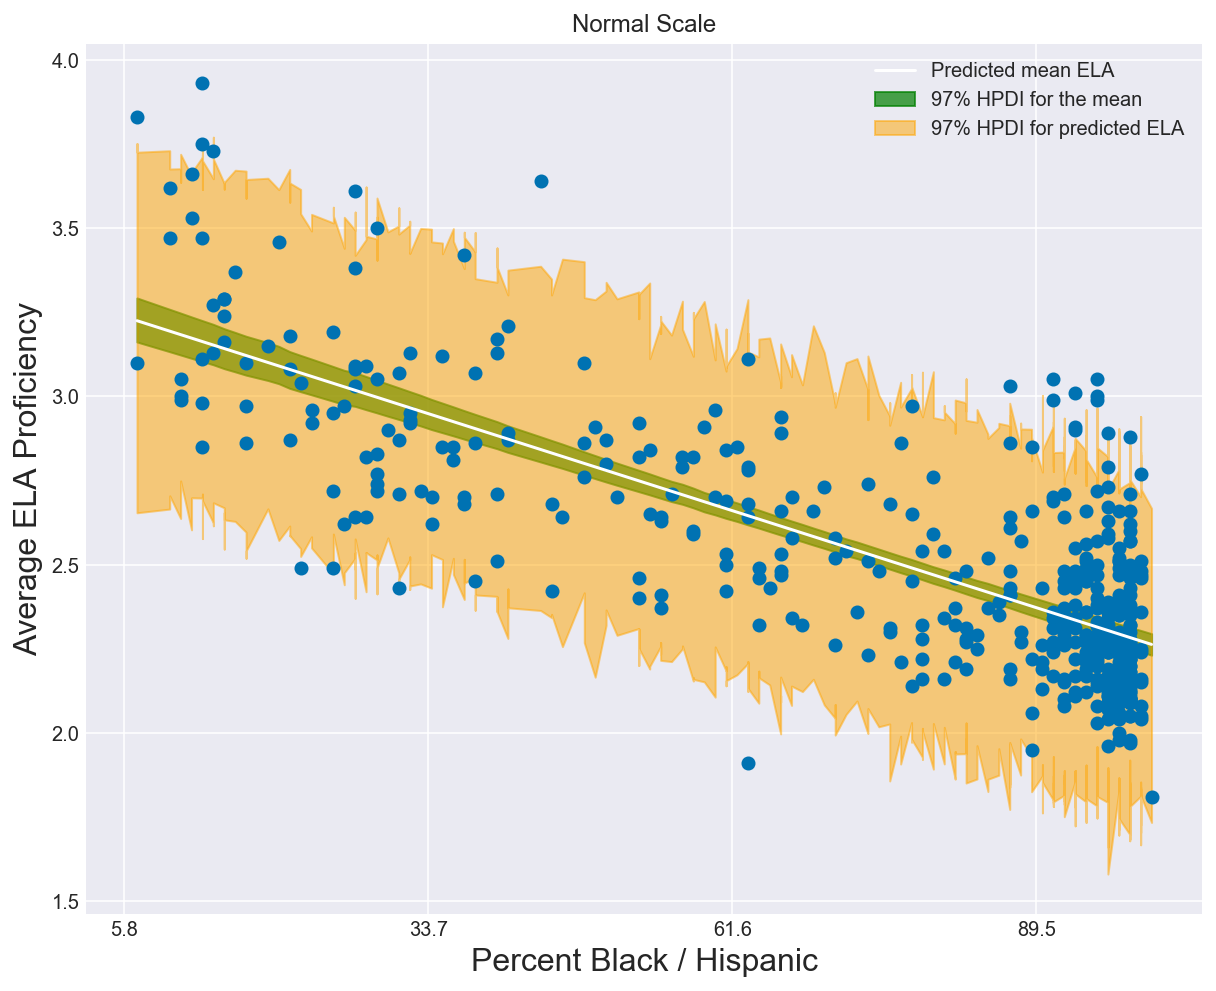

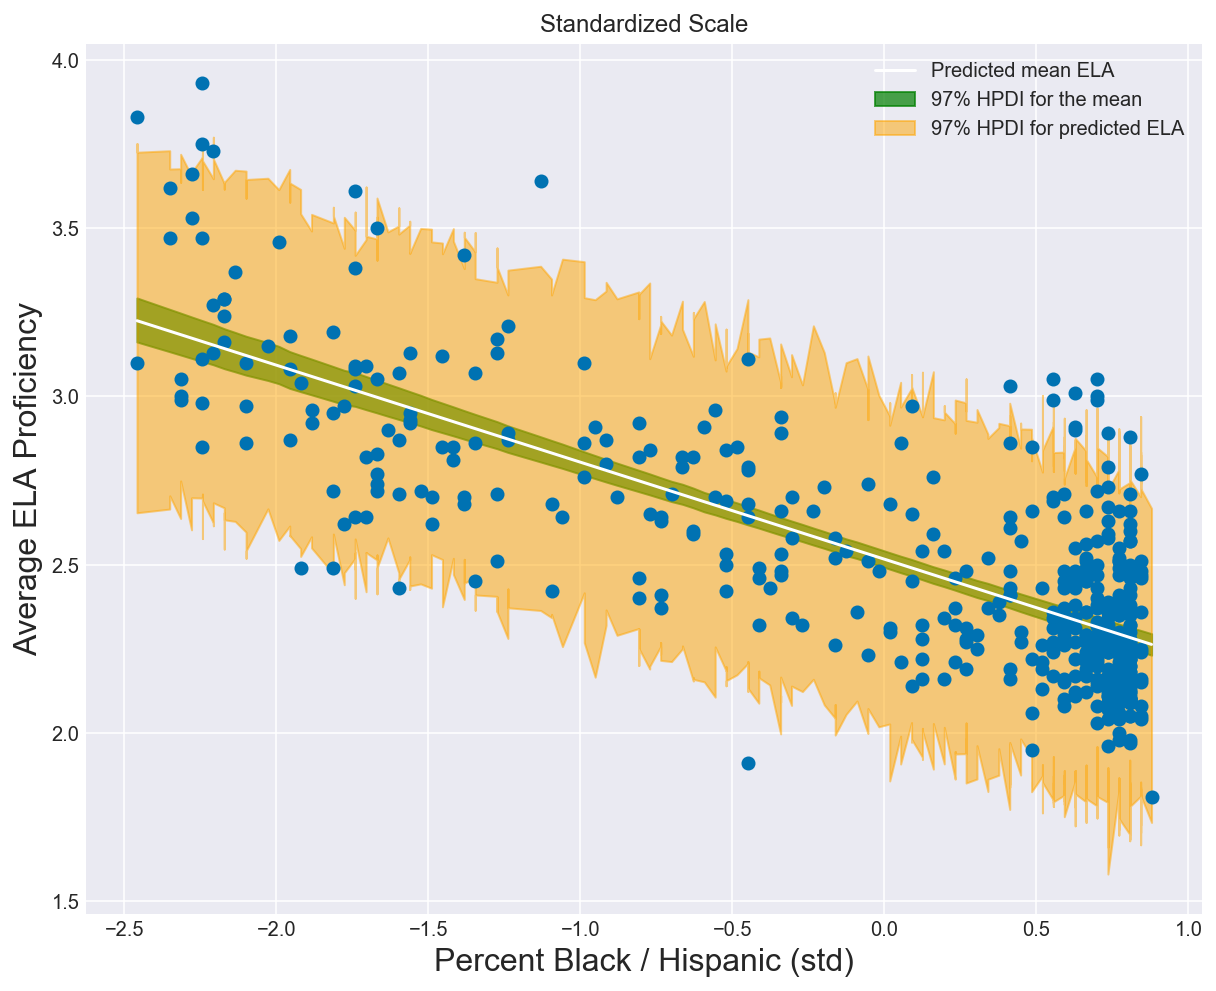

In [101]:
plt.figure(figsize=(10,8))

# plot the Percent Black / Hispanic vs. ELA proficiencies
plt.plot(df2['stdized_HispBlck'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Percent Black / Hispanic (this is the regression line)
plt.plot(df2['stdized_HispBlck'], trace_r_2['α'].mean() + trace_r_2['β'].mean() * 
         df2['stdized_HispBlck'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_HispBlck'], mean_97_r2[:,0], mean_97_r2[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_HispBlck'], pred_ELA_97_r2[:,0], pred_ELA_97_r2[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Normal Scale")
plt.xlabel("Percent Black / Hispanic", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()


#convert back to natural scale.
at = np.arange(-2.5,1)
plt.xticks(at, np.round(at * df2['Percent Black / Hispanic'].std() + 
                        df2['Percent Black / Hispanic'].mean(), 1))

plt.show()
plt.close()


plt.figure(figsize=(10,8))

# plot the Percent Black / Hispanic vs. ELA proficiencies
plt.plot(df2['stdized_HispBlck'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Percent Black / Hispanic (this is the regression line)
plt.plot(df2['stdized_HispBlck'], trace_r_2['α'].mean() + trace_r_2['β'].mean() * 
         df2['stdized_HispBlck'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_HispBlck'], mean_97_r2[:,0], mean_97_r2[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_HispBlck'], pred_ELA_97_r2[:,0], pred_ELA_97_r2[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Percent Black / Hispanic (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()

plt.show()

In [42]:
# Correlations between parameters

df_trace_r2 = pm.trace_to_dataframe(trace_r_2, varnames=['α','β','σ'])
df_trace_r2.corr().round(2)

α     β     σ
α  1.00  0.00  0.01
β  0.00  1.00 -0.02
σ  0.01 -0.02  1.00

# Economic Need Index as predictor of ELA Proficiency

**Definitions:**

**Economic need index** is based on the % of students that are in temporary housing + the % of students that are eligible to receive cash assistance + % of students eligible for free lunch. The higher the index, the higher the need.

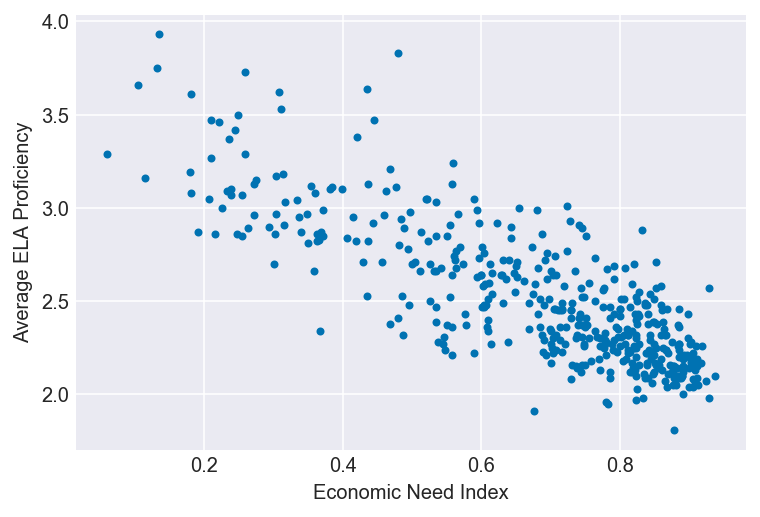

In [43]:
plt.plot(df2['Economic Need Index'],df2['Average ELA Proficiency'],  '.')
plt.xlabel("Economic Need Index")
plt.ylabel("Average ELA Proficiency");

In [44]:
# Sort predictor for plotting purposes later on
df2.sort_values('Economic Need Index', inplace=True)

In [45]:
# Standardize the predictor
df2['stdized_ENI']=(df2['Economic Need Index']-df2['Economic Need Index'].mean())/np.std(
    df2['Economic Need Index'])

\begin{aligned}
ELA_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β*ENI_i\\
α &\sim Normal(2,5)\\
β &\sim Uniform(-2,0)\\
σ &\sim Uniform(0,5)
\end{aligned}

In [46]:
with pm.Model() as r_3:
    α = pm.Normal('α', 2, 5)
    β = pm.Uniform('β', -2, 0) # Uniform because there is no chance that the slope is positive
    σ = pm.Uniform('σ', 0, 1)
    μ = pm.Deterministic('μ', α + β * df2['stdized_ENI'])
    
    ela_prof = pm.Normal('ela_prof', mu=μ, sd=σ, observed=df2['Average ELA Proficiency'])
    trace_r_3 = pm.sample(5000, tune=3000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, β, α]
100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1011.37it/s]


In [47]:
pm.summary(trace_r_3).head().round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
α     2.52  0.01       0.0     2.50      2.54  15534.42   1.0
β    -0.30  0.01       0.0    -0.32     -0.28  13118.52   1.0
σ     0.22  0.01       0.0     0.20      0.23  14874.36   1.0
μ__0  3.45  0.03       0.0     3.39      3.52  13368.57   1.0
μ__1  3.38  0.03       0.0     3.32      3.44  13404.11   1.0

Summary:
* β- for every 1 standard deviation increase in "Economic Need Index" , the school is expected to see a decrease in its average ELA proficiency of 0.30.  
* μ- the average mean of all "Average ELA proficiencies" is 2.51
* σ- 95% of plausible "Average ELA proficiencies" lie within 0.44 (2σ) of the mean, that is, 2.51+-0.44
* α- given that we standardized the "Economic Need Index" variable, its mean is the same as the mean of "Average ELA proficiencies".

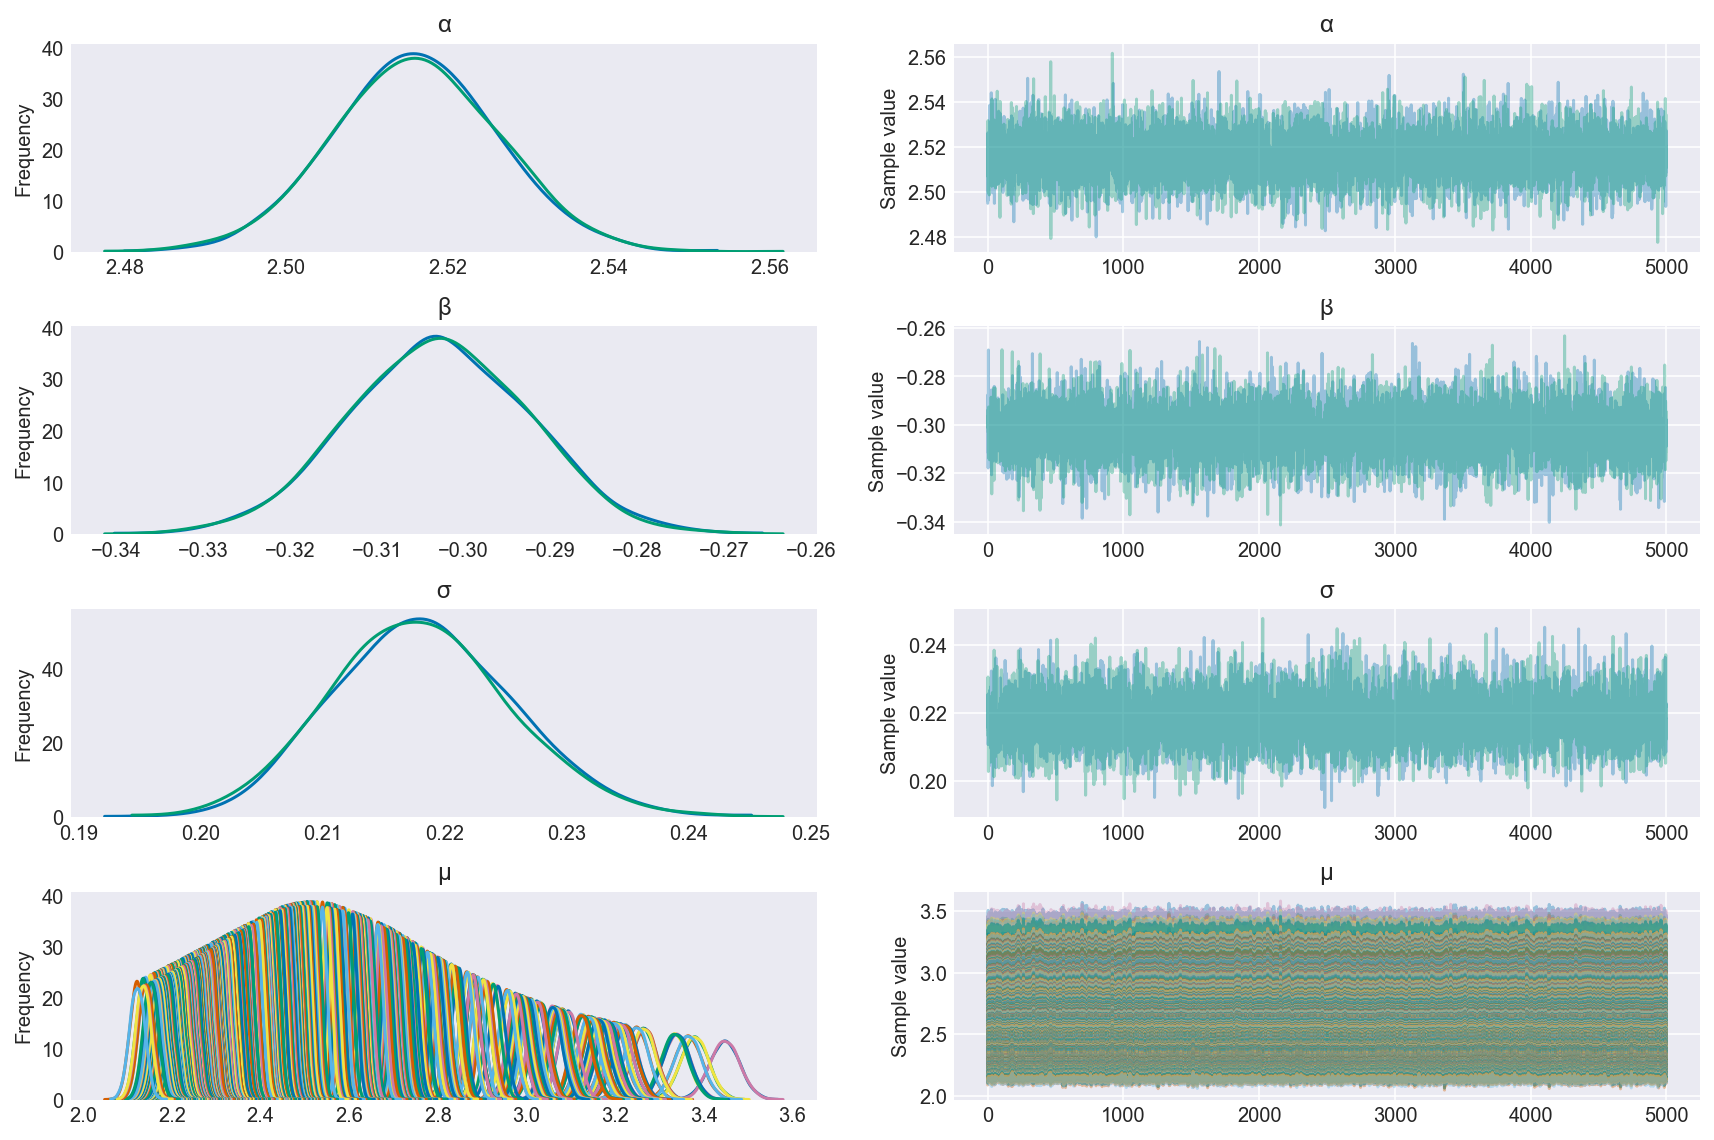

In [48]:
pm.traceplot(trace_r_3);

In [49]:
# 97% HPDI for the mean
mean_97_r3 = pm.hpd(trace_r_3['μ'], alpha=0.03)

# 97% HPDI for predicted Average ELA Proficiencies
pred_ELA_r3 = pm.sample_ppc(trace_r_3, 300, r_3) 
pred_ELA_97_r3 = pm.hpd(pred_ELA_r3['ela_prof'], alpha=0.03)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 21.26it/s]


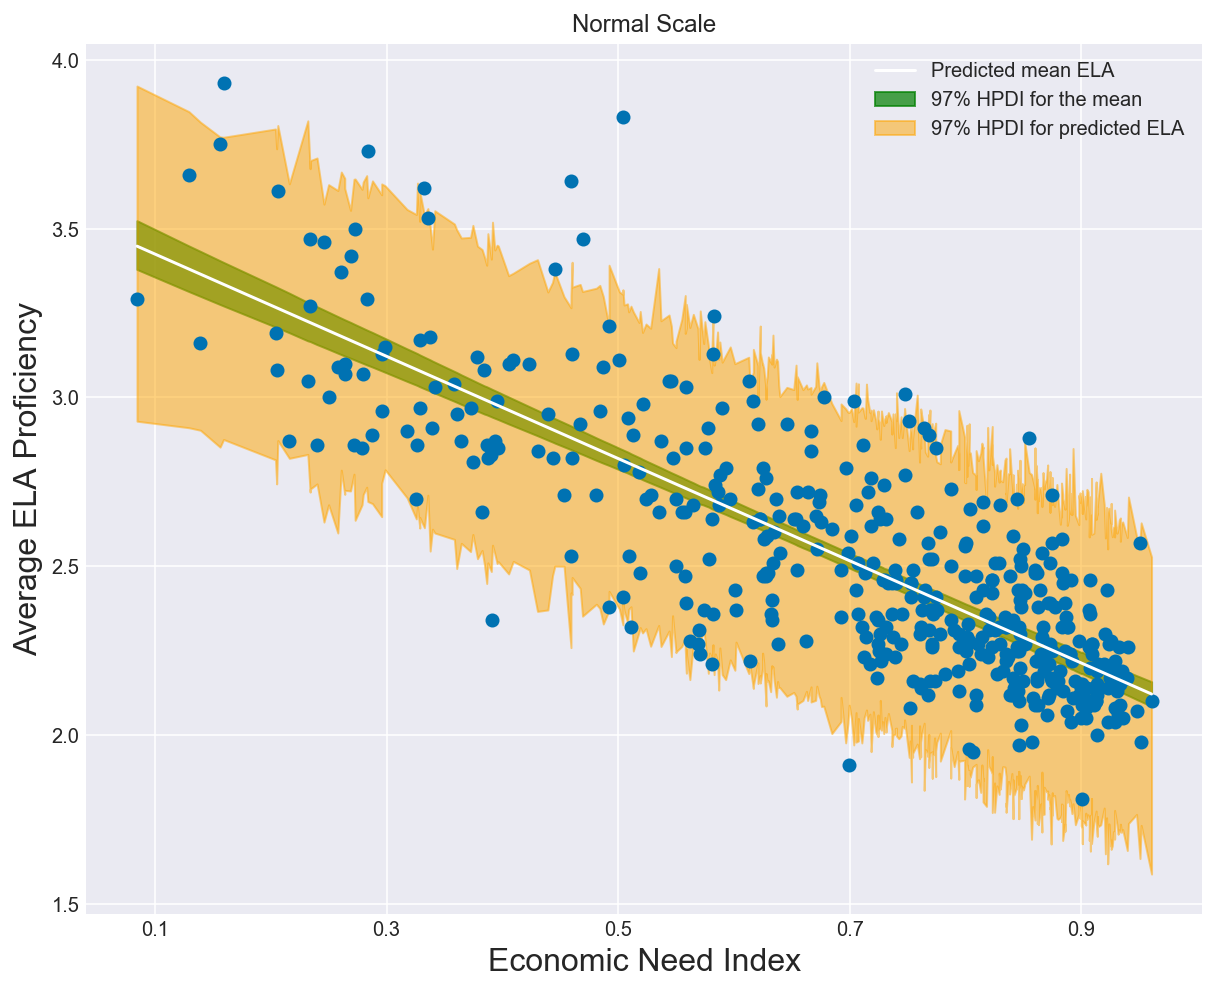

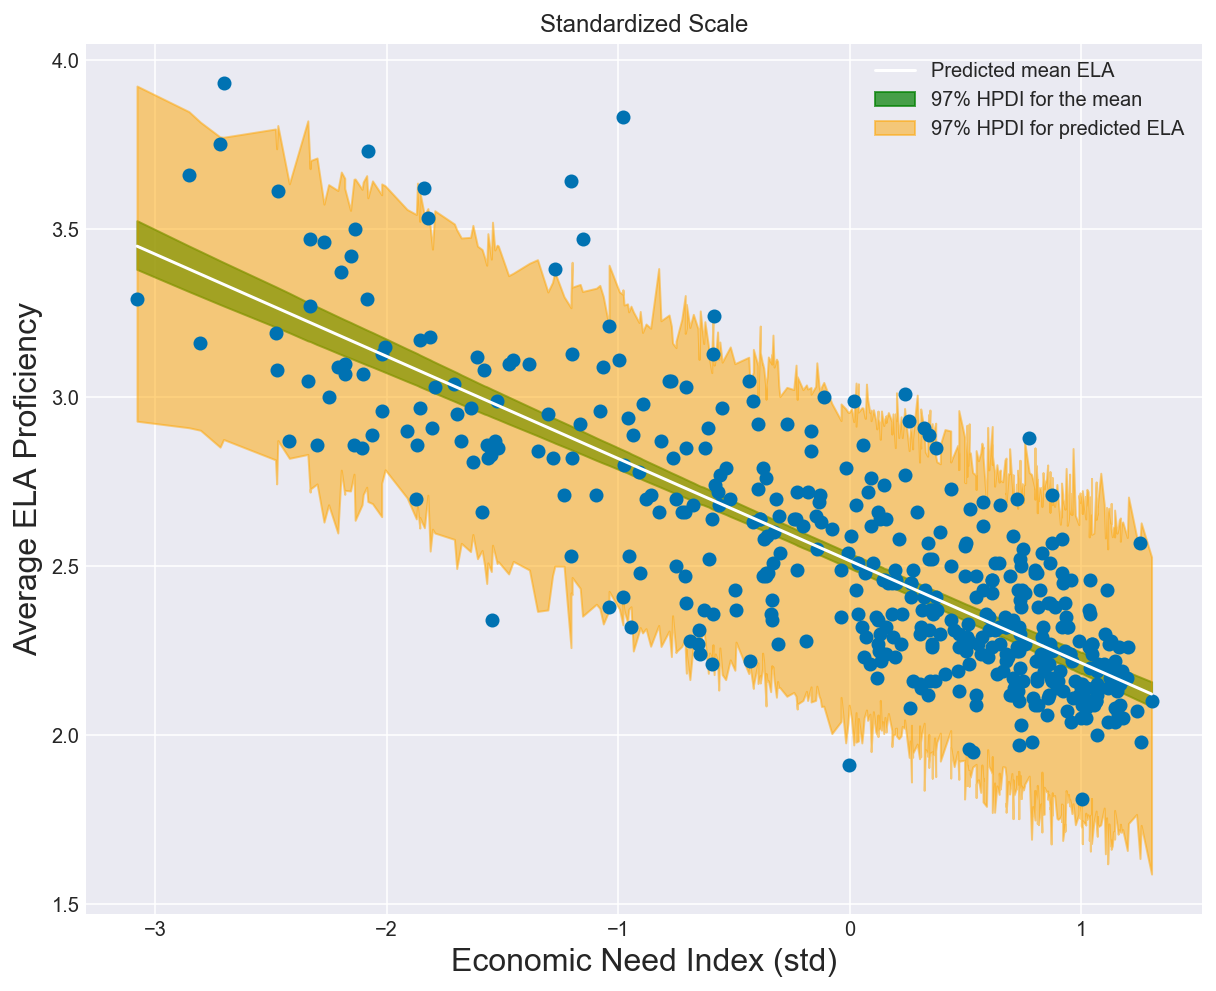

In [50]:
plt.figure(figsize=(10,8))

# plot the Economic Need Index vs. ELA proficiencies
plt.plot(df2['stdized_ENI'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Economic Need Index (this is the regression line)
plt.plot(df2['stdized_ENI'], trace_r_3['α'].mean() + trace_r_3['β'].mean() * 
         df2['stdized_ENI'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_ENI'], mean_97_r3[:,0], mean_97_r3[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_ENI'], pred_ELA_97_r3[:,0], pred_ELA_97_r3[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Normal Scale")
plt.xlabel("Economic Need Index", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()


# convert back to natural scale.
at = np.arange(-3,1.5)
plt.xticks(at, np.round(at * df2['Economic Need Index'].std() + 
                        df2['Economic Need Index'].mean(), 1))

plt.show()
plt.close()


plt.figure(figsize=(10,8))

# plot the Economic Need Index vs. ELA proficiencies
plt.plot(df2['stdized_ENI'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Economic Need Index (this is the regression line)
plt.plot(df2['stdized_ENI'], trace_r_3['α'].mean() + trace_r_3['β'].mean() * 
         df2['stdized_ENI'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_ENI'], mean_97_r3[:,0], mean_97_r3[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_ENI'], pred_ELA_97_r3[:,0], pred_ELA_97_r3[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Economic Need Index (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()

plt.show()

In [51]:
# Correlations between parameters

df_trace_r3 = pm.trace_to_dataframe(trace_r_3, varnames=['α','β','σ'])
df_trace_r3.corr().round(2)


α     β     σ
α  1.00  0.01  0.01
β  0.01  1.00  0.01
σ  0.01  0.01  1.00

# Average Math Proficiency as predictor of ELA Proficiency

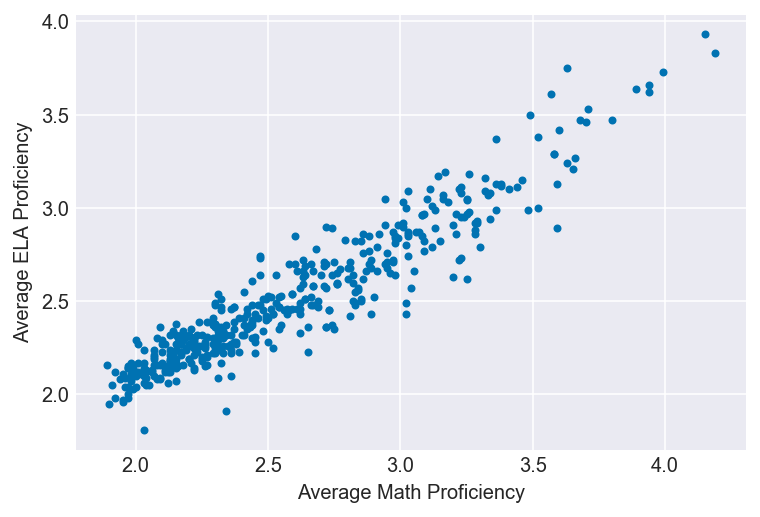

In [52]:
plt.plot(df2['Average Math Proficiency'],df2['Average ELA Proficiency'],  '.')
plt.xlabel("Average Math Proficiency")
plt.ylabel("Average ELA Proficiency");

In [53]:
# Sort predictor for plotting purposes later on
df2.sort_values('Average Math Proficiency', inplace=True)

In [54]:
# Standardize the predictor
df2['stdized_Math']=(df2['Average Math Proficiency']-df2['Average Math Proficiency'].mean())/np.std(
    df2['Average Math Proficiency'])

\begin{aligned}
ELA_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β*Math_i\\
α &\sim Normal(2,5)\\
β &\sim Uniform(0,2)\\
σ &\sim Uniform(0,5)
\end{aligned}

In [55]:
with pm.Model() as r_4:
    α = pm.Normal('α', 2, 5)  # 2 because we standardized the predictor, so its average = average of ELA (~ 2.5)
    β = pm.Uniform('β', 0, 2) # Uniform because there is no chance that the slope is negative
    σ = pm.Uniform('σ', 0, 5)
    μ = pm.Deterministic('μ', α + β * df2['stdized_Math'])
    
    ela_prof = pm.Normal('ela_prof', mu=μ, sd=σ, observed=df2['Average ELA Proficiency'])
    trace_r_4 = pm.sample(5000, tune=3000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, β, α]
100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:08<00:00, 988.39it/s]


In [56]:
pm.summary(trace_r_4).head().round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
α     2.52  0.01       0.0     2.50      2.53  15523.27   1.0
β     0.35  0.01       0.0     0.34      0.36  14896.25   1.0
σ     0.12  0.00       0.0     0.12      0.13  14174.47   1.0
μ__0  2.01  0.01       0.0     1.99      2.03  15190.36   1.0
μ__1  2.01  0.01       0.0     1.99      2.03  15194.88   1.0

Summary:
* β- for every 1 standard deviation increase in "Average Math Proficiency" , the school is expected to see an increase in its average ELA proficiency of 0.35.  
* μ- the average mean of all "Average ELA proficiencies" is 2.51
* σ- 95% of plausible "Average ELA proficiencies" lie within 0.24 (2σ) of the mean, that is, 2.51+-0.24
* α- given that we standardized the "Economic Need Index" variable, its mean is the same as the mean of "Average ELA proficiencies".

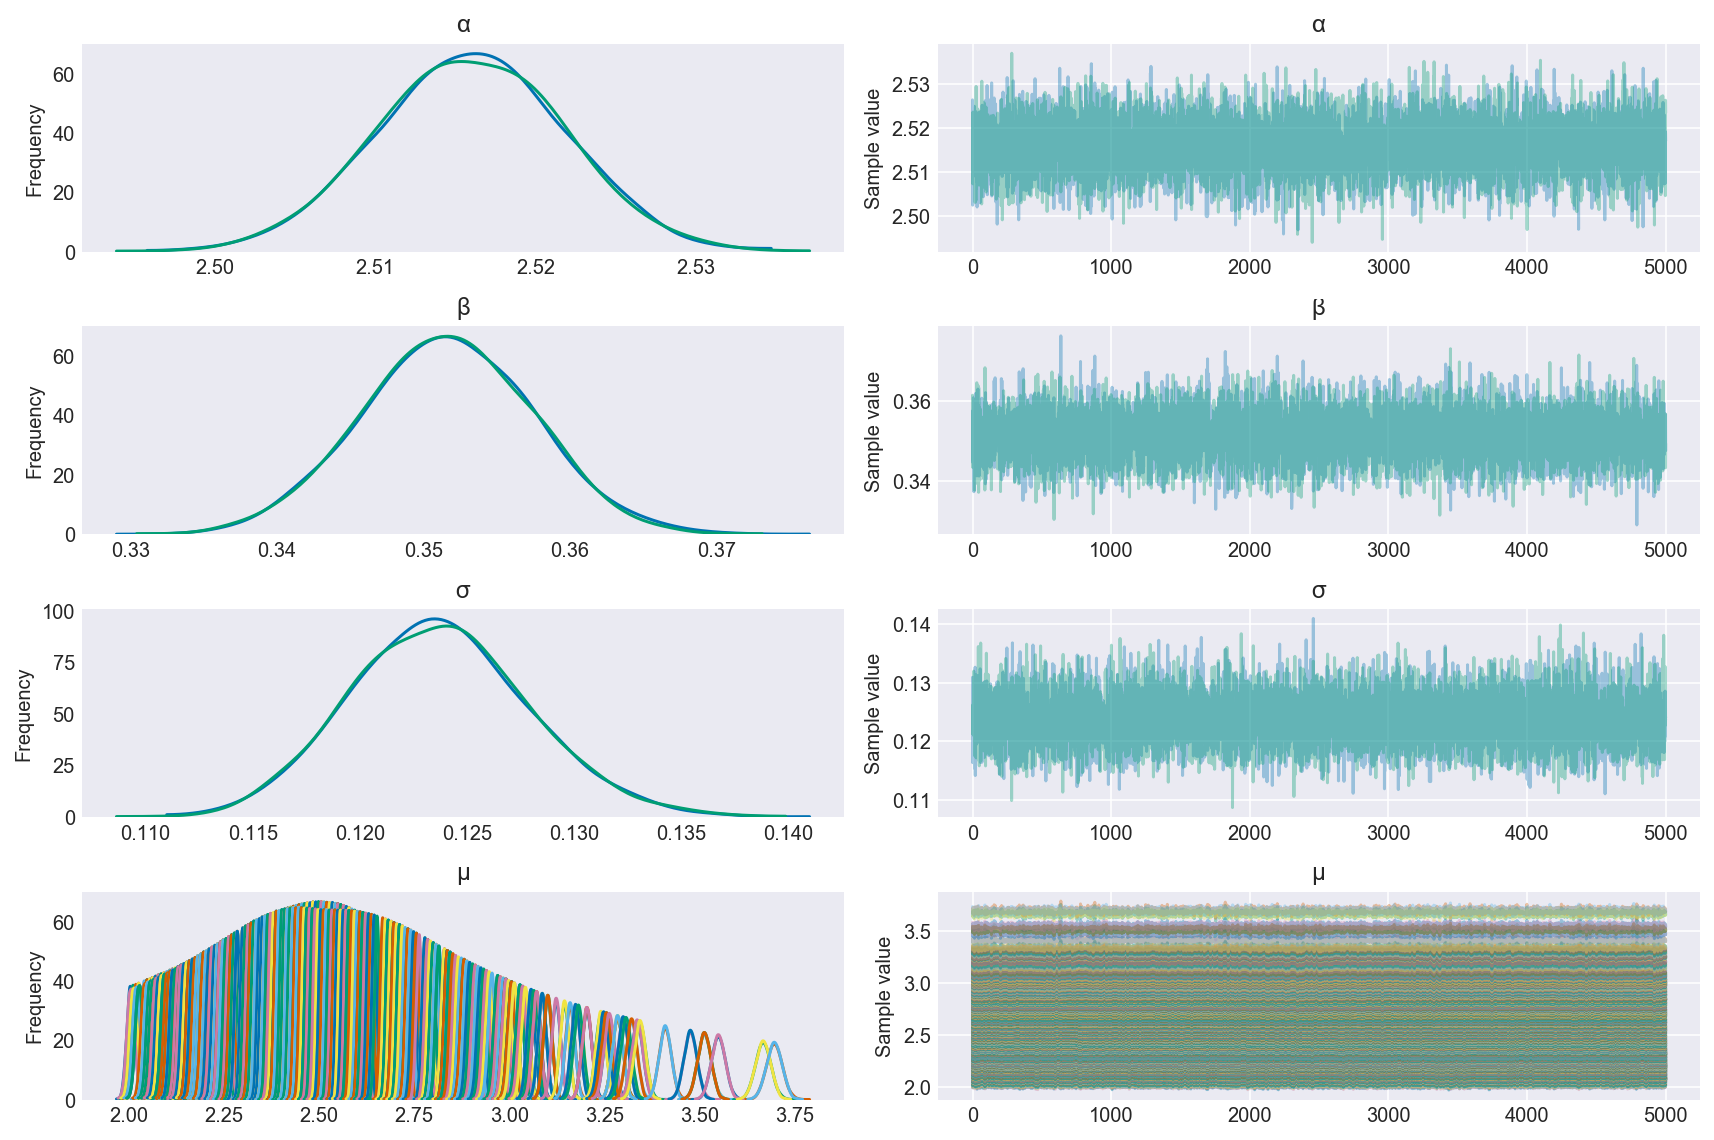

In [57]:
pm.traceplot(trace_r_4);

In [58]:
# 97% HPDI for the mean
mean_97_r4 = pm.hpd(trace_r_4['μ'], alpha=0.03)

# 97% HPDI for predicted Average ELA Proficiencies
pred_ELA_r4 = pm.sample_ppc(trace_r_4, 300, r_4) 
pred_ELA_97_r4 = pm.hpd(pred_ELA_r4['ela_prof'], alpha=0.03)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.15it/s]


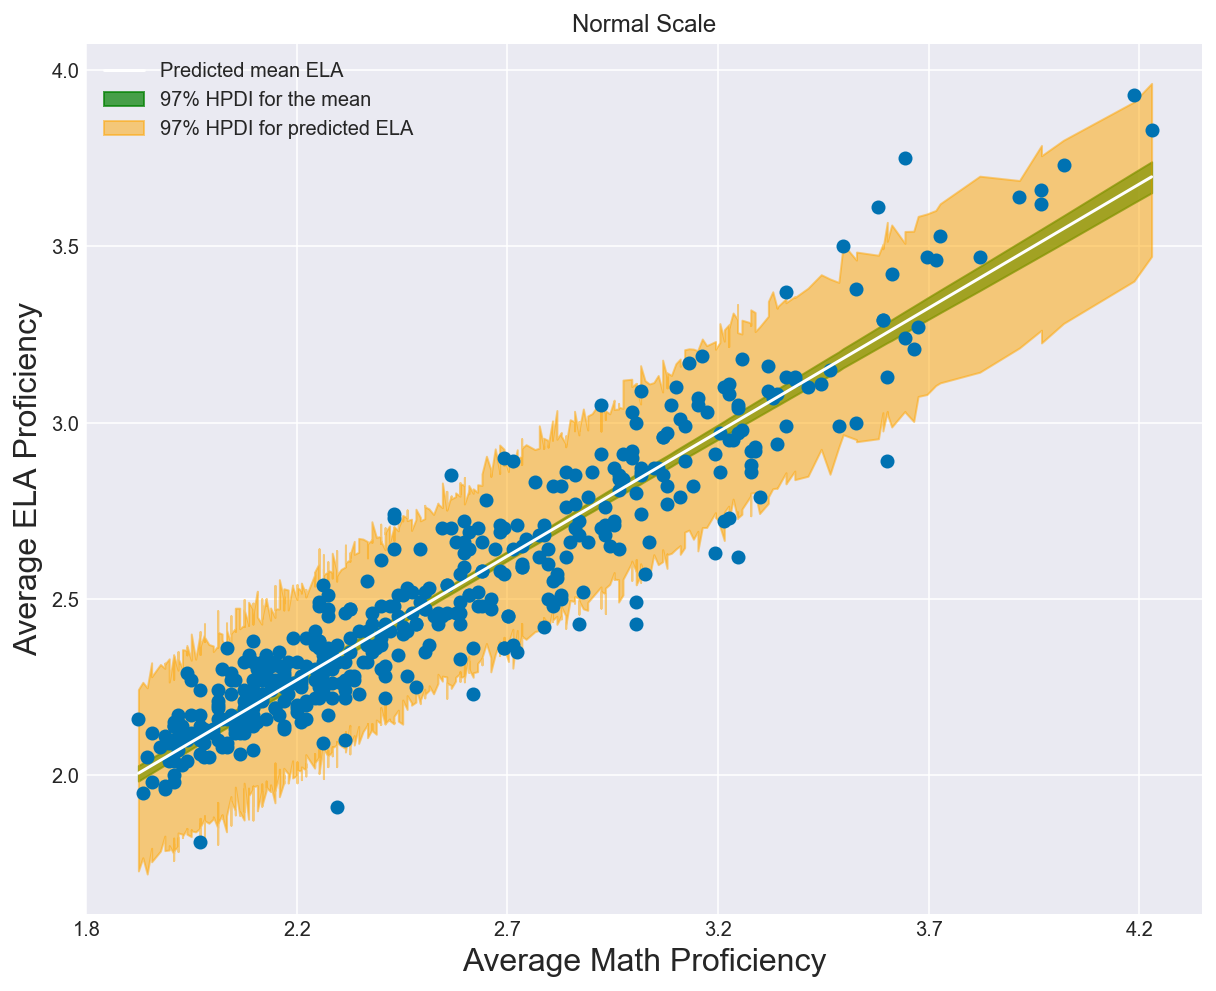

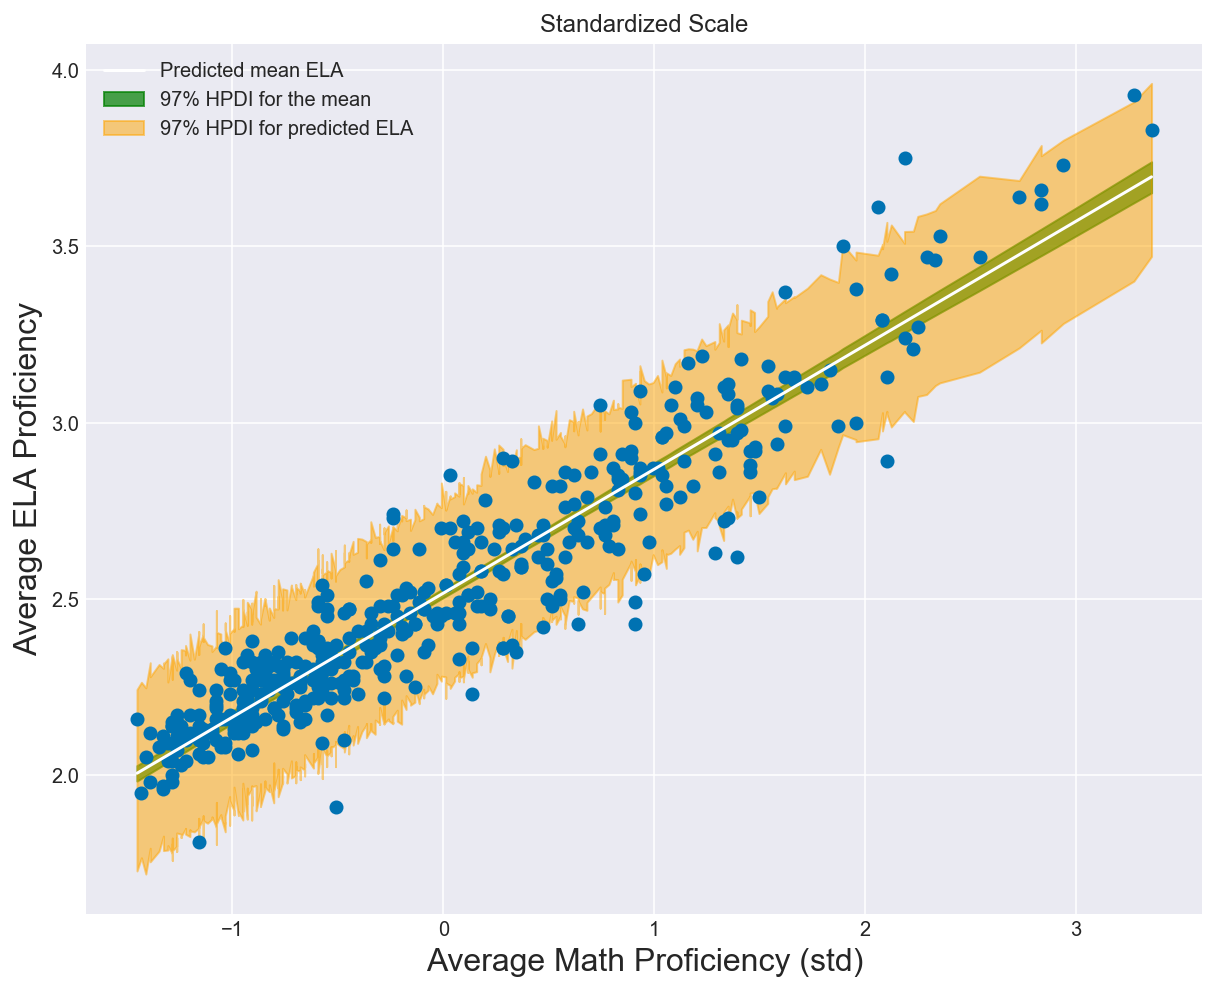

In [59]:
plt.figure(figsize=(10,8))

# plot the Average Math Proficiency vs. Average ELA proficiencies
plt.plot(df2['stdized_Math'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Average Math Proficiency (this is the regression line)
plt.plot(df2['stdized_Math'], trace_r_4['α'].mean() + trace_r_4['β'].mean() * 
         df2['stdized_Math'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_Math'], mean_97_r4[:,0], mean_97_r4[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_Math'], pred_ELA_97_r4[:,0], pred_ELA_97_r4[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Normal Scale")
plt.xlabel("Average Math Proficiency", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()


# convert back to natural scale.
at = np.arange(-1.7,4)
plt.xticks(at, np.round(at * df2['Average Math Proficiency'].std() + 
                        df2['Average Math Proficiency'].mean(), 1))

plt.show()
plt.close()


plt.figure(figsize=(10,8))

# plot the Average Math Proficiency vs. Average ELA proficiencies
plt.plot(df2['stdized_Math'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Average Math Proficiency (this is the regression line)
plt.plot(df2['stdized_Math'], trace_r_4['α'].mean() + trace_r_4['β'].mean() * 
         df2['stdized_Math'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_Math'], mean_97_r4[:,0], mean_97_r4[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_Math'], pred_ELA_97_r4[:,0], pred_ELA_97_r4[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Average Math Proficiency (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()


plt.show()

In [60]:
# Correlations between parameters

df_trace_r4 = pm.trace_to_dataframe(trace_r_4, varnames=['α','β','σ'])
df_trace_r4.corr().round(2)

α     β     σ
α  1.00  0.01  0.01
β  0.01  1.00 -0.02
σ  0.01 -0.02  1.00

# Compare Findings

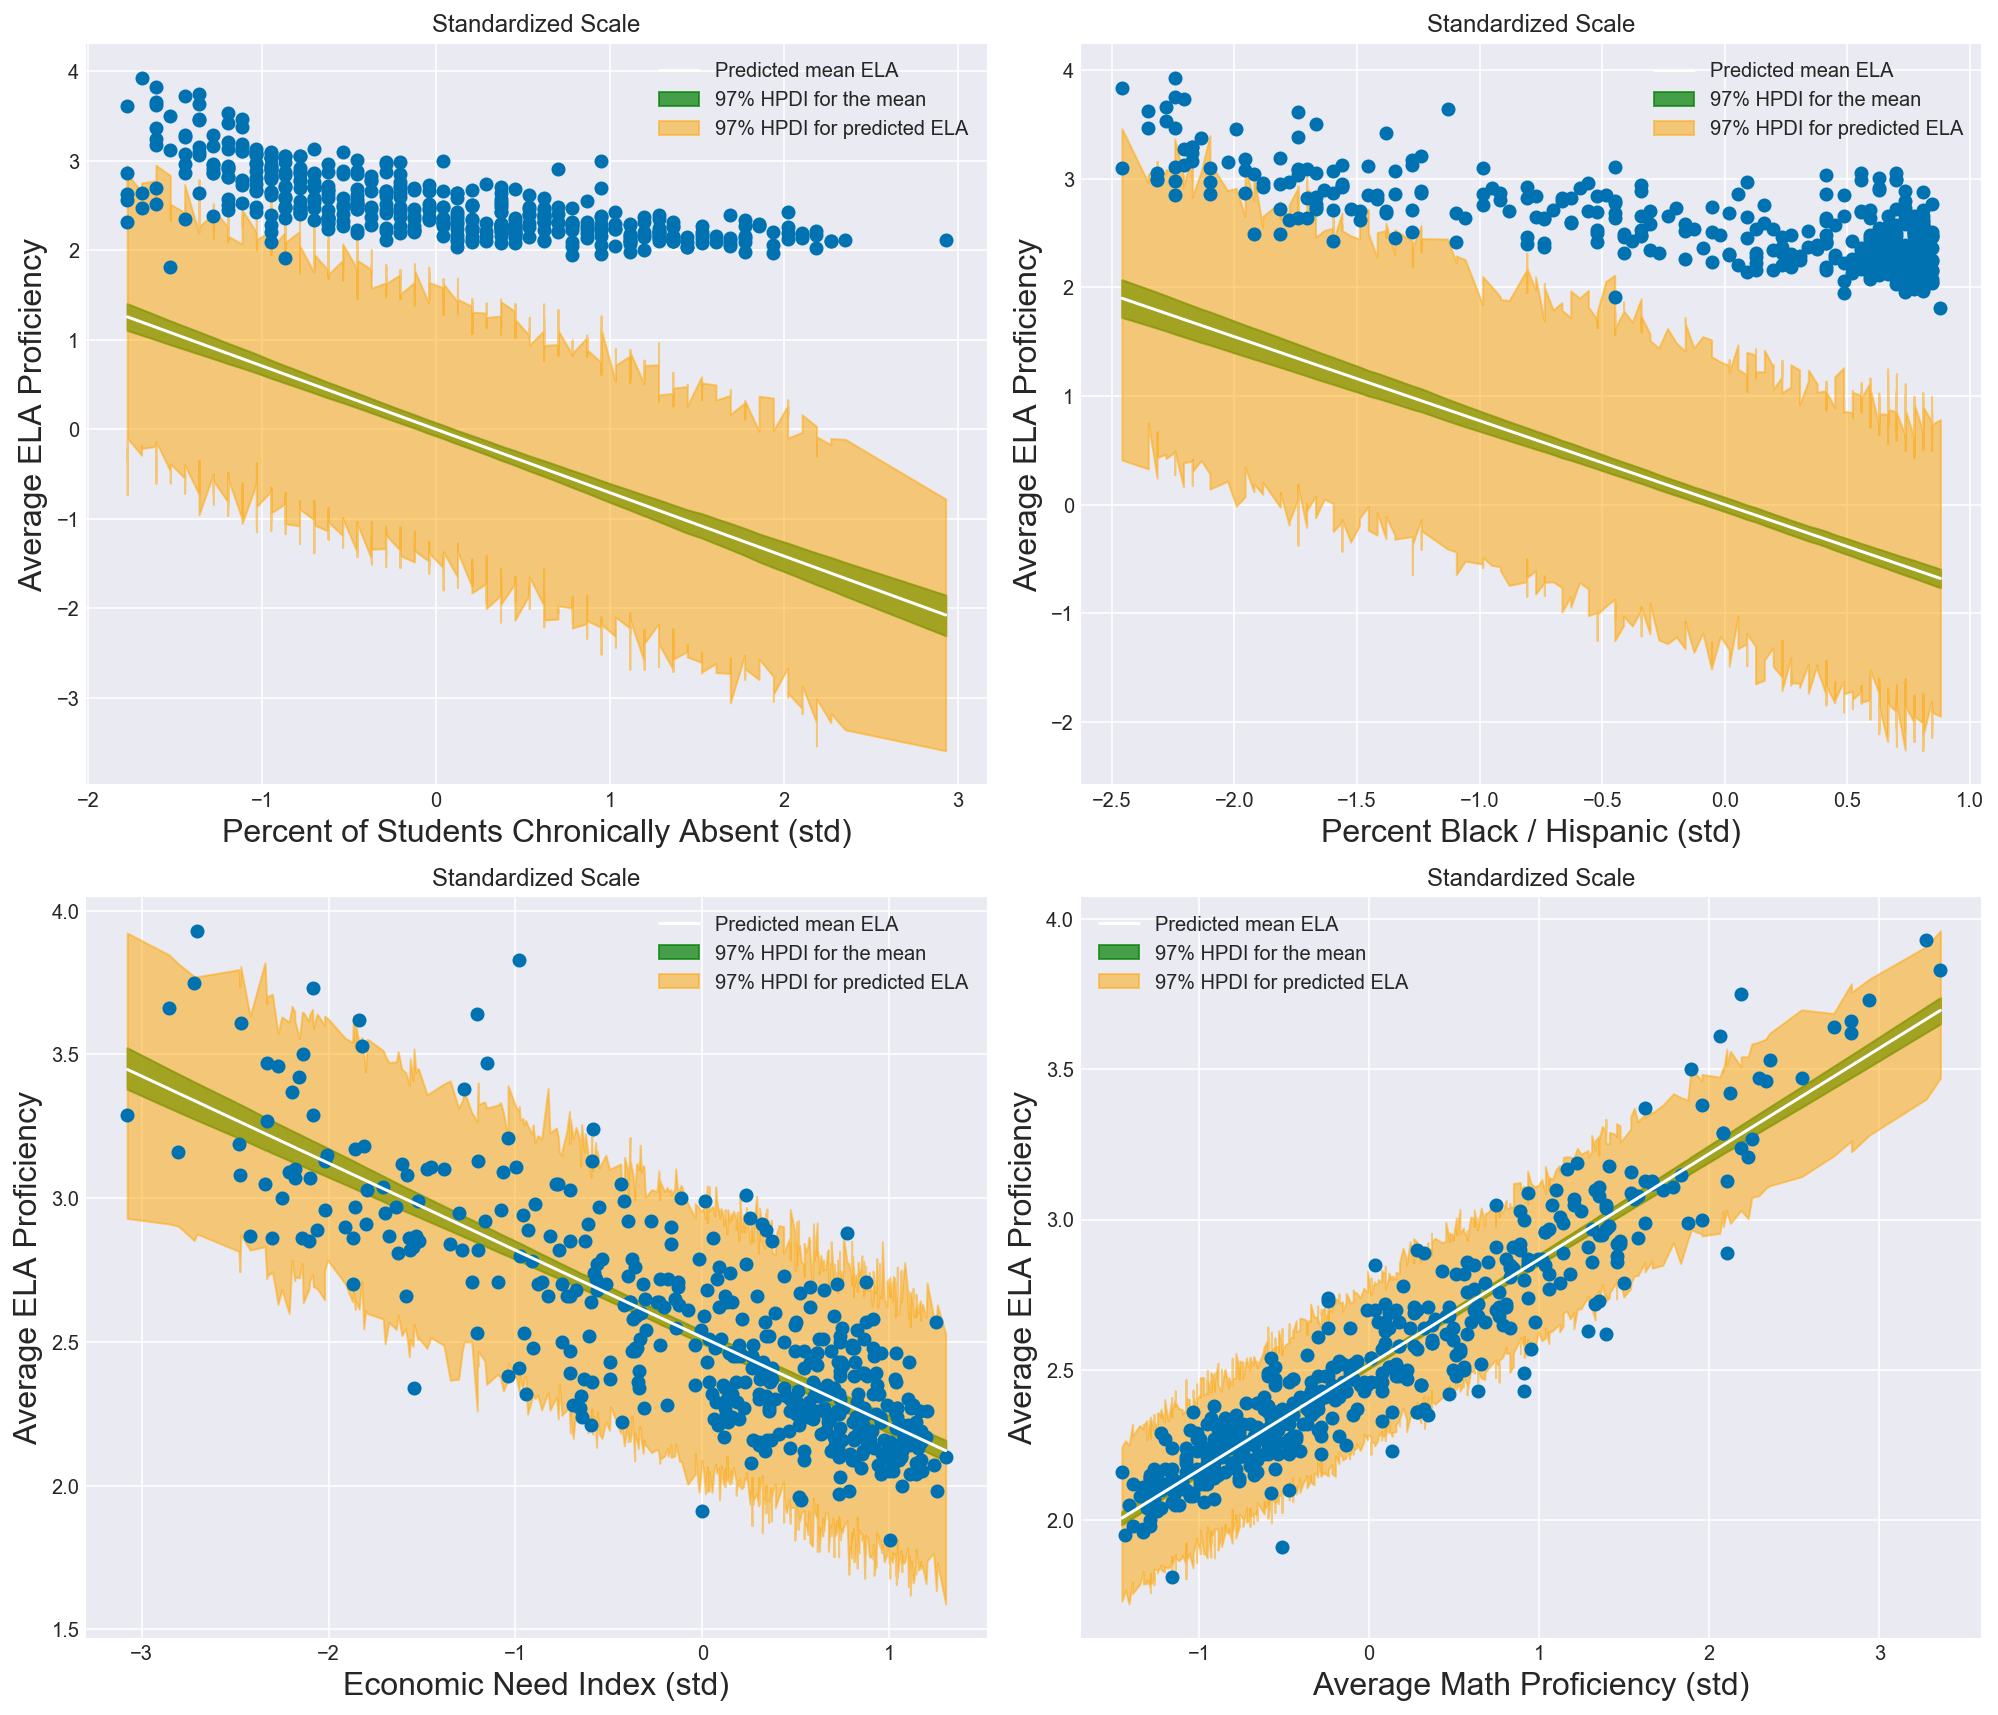

In [94]:
plt.figure(figsize=(14,12))

plt.subplot(2, 2, 1)
df2.sort_values('Percent of Students Chronically Absent', inplace=True)

# plot the Chronic absences vs. ELA proficiencies
plt.plot(df2['stdized_absence'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of absences (this is the regression line)
plt.plot(df2['stdized_absence'], trace_r_1['α'].mean() + trace_r_1['β'].mean() * 
         df2['stdized_absence'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_absence'], mean_97_r1[:,0], mean_97_r1[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_absence'], pred_ELA_97_r1[:,0], pred_ELA_97_r1[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Percent of Students Chronically Absent (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()


#-------------------------------------------------------------------------------------------


plt.subplot(2, 2, 2)
df2.sort_values('Percent Black / Hispanic', inplace=True)
# plot the Percent Black / Hispanic vs. ELA proficiencies
plt.plot(df2['stdized_HispBlck'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Percent Black / Hispanic (this is the regression line)
plt.plot(df2['stdized_HispBlck'], trace_r_2['α'].mean() + trace_r_2['β'].mean() * 
         df2['stdized_HispBlck'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_HispBlck'], mean_97_r2[:,0], mean_97_r2[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_HispBlck'], pred_ELA_97_r2[:,0], pred_ELA_97_r2[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Percent Black / Hispanic (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()



#-------------------------------------------------------------------------------------------


plt.subplot(2, 2, 3)
df2.sort_values('Economic Need Index', inplace=True)

# plot the Economic Need Index vs. ELA proficiencies
plt.plot(df2['stdized_ENI'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Economic Need Index (this is the regression line)
plt.plot(df2['stdized_ENI'], trace_r_3['α'].mean() + trace_r_3['β'].mean() * 
         df2['stdized_ENI'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_ENI'], mean_97_r3[:,0], mean_97_r3[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_ENI'], pred_ELA_97_r3[:,0], pred_ELA_97_r3[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Economic Need Index (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()

#-------------------------------------------------------------------------------------------

plt.subplot(2, 2, 4)
df2.sort_values('Average Math Proficiency', inplace=True)

# plot the Average Math Proficiency vs. Average ELA proficiencies
plt.plot(df2['stdized_Math'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of Average Math Proficiency (this is the regression line)
plt.plot(df2['stdized_Math'], trace_r_4['α'].mean() + trace_r_4['β'].mean() * 
         df2['stdized_Math'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_Math'], mean_97_r4[:,0], mean_97_r4[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_Math'], pred_ELA_97_r4[:,0], pred_ELA_97_r4[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Standardized Scale")
plt.xlabel("Average Math Proficiency (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()


plt.tight_layout()
plt.savefig("All_regressions")

In [92]:
print("Slope of regression when predictor is:")
print("\nChronic absence: {}".format(trace_r_1['β'].mean()))
print("Hispanic-Black: {}".format(trace_r_2['β'].mean()))
print("Economic Need: {}".format(trace_r_3['β'].mean()))
print("Math Proficiency: {}".format(trace_r_4['β'].mean()))

Slope of regression when predictor is:

Chronic absence: -0.7081717723029173
Hispanic-Black: -0.7726144973630912
Economic Need: -0.3028100481970656
Math Proficiency: 0.3516144180013126


In [93]:
print("Standard Deviation when predictor is:")
print("\nChronic Absence: {}".format(trace_r_1['σ'].mean()))
print("Hispanic-Black: {}".format(trace_r_2['σ'].mean()))
print("Economic Need: {}".format(trace_r_3['σ'].mean()))
print("Math Proficiency: {}".format(trace_r_4['σ'].mean()))

Standard Deviation when predictor is:

Chronic Absence: 0.7080560597005281
Hispanic-Black: 0.6362350470979642
Economic Need: 0.21817274776562862
Math Proficiency: 0.12371495921836492


**Summary:**
* The 97% HPDI for predicted ELA proficiency is narrowest when Math is the predictor.
* The 97% HPDI for predicted ELA proficiency helps us identify outliers. Outliers, should be equally distributed over the parameter range (orange), which is why we see that the linear regression is not the best fit when "Chronically Absent" is the predictor
* When % of Black-Hispanic is the predictor, the 97% HPDI of the mean, for predicted ELA proficiency, is at its narrowest (very little green around the white regression line) when the predictor values are +1 standard deviations, but it grows wider (larger intervals=more uncertainty) as the values increase in standard deviation to the left.
* How much something predicts depends also on the distribution of values. For example, the model, where Black-Hispanic is the predictor, has most of its values > 0.5 standard deviations. So it might have difficulties predicting outcomes for schools where hispanic-black populations are low (schools with a majority of white students). 
* The slope of Math Proficieny is the one furthest away from zero (0.35), which means it's probably the best predictor to explain the linear rate of change of ELA proficiency.
* The σ should be interpreted here as the model residual. A lower model residual means that the variable x explains more of the variation in y.

We could try to combine the models and add beta’s for all your predictors in the same model, possibly even as a multivariate structure to account for correlations. That makes it harder to interpret, but the model should be more accurate.

To estimate which is the strongest predictor, we can have four extra models where one of all the slopes is left out in turn. Then we can do model comparison / LOO, to compare the predictive power of the reduced models with the full one.

# -------------------------------------Addendum Section------------------------------------------

# Second Order Polynomial Regression 

In [90]:
df2.sort_values('Percent of Students Chronically Absent', inplace=True)

In [91]:
#compute the squared std outside the model
df2['stdized_absence_2'] = df2.stdized_absence**2

\begin{aligned}
ELA_i &\sim Normal(μ_i,σ)\\
μ_i &= α + β_0*Absnt_i + β_1*Absnt_i^2\\
α &\sim Normal(0,5)\\
β_0 &\sim Normal(0,10)\\
β_1 &\sim Normal(0,10)\\
σ &\sim Uniform(0,10)
\end{aligned}

In [92]:
with pm.Model() as r_5:
    α = pm.Normal('α', 0, 5)
    β = pm.Normal('β', 0, 10, shape=2)
    σ = pm.Uniform('σ', 0, 10)
    μ = pm.Deterministic('μ', α + β[0] * df2['stdized_absence'] + β[1] * df2['stdized_absence_2'])
    
    ela_prof = pm.Normal('ela_prof', mu=μ, sd=σ, observed=df2['Average ELA Proficiency'])
    trace_r_5 = pm.sample(5000, tune=3000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, β, α]
100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:14<00:00, 547.41it/s]


In [98]:
pm.summary(trace_r_5, varnames=['α','β','σ']).round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
α     2.44  0.02       0.0     2.41      2.47   7312.71   1.0
β__0 -0.29  0.01       0.0    -0.31     -0.27   8116.74   1.0
β__1  0.07  0.01       0.0     0.05      0.10   6659.32   1.0
σ     0.25  0.01       0.0     0.24      0.27  10908.47   1.0

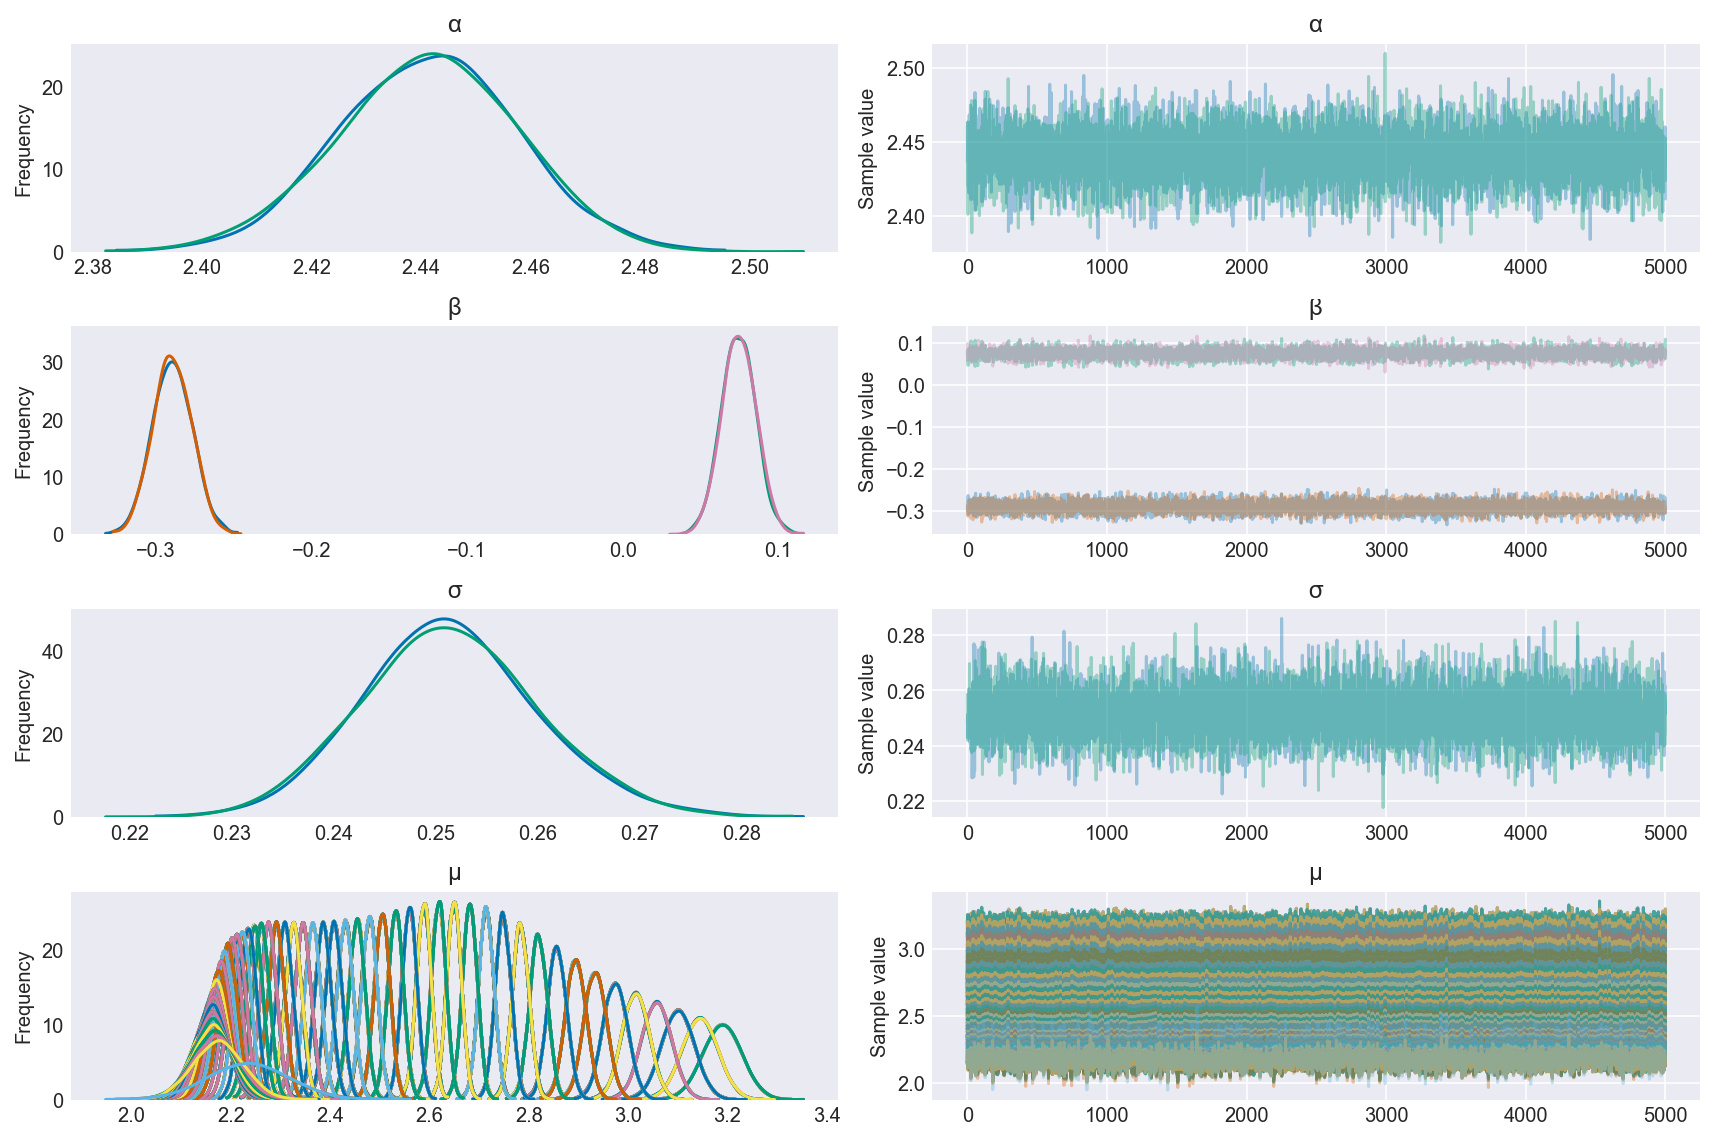

In [99]:
pm.traceplot(trace_r_5);

In [106]:
# 97% HPDI for the mean
mean_97_r5 = pm.hpd(trace_r_5['μ'], alpha=0.03)

# 97% HPDI for predicted ELA
pred_r5 = pm.sample_ppc(trace_r_5, 300, r_5) 
pred_ELA_97_r5 = pm.hpd(pred_r5['ela_prof'], alpha=0.03)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 960.04it/s]


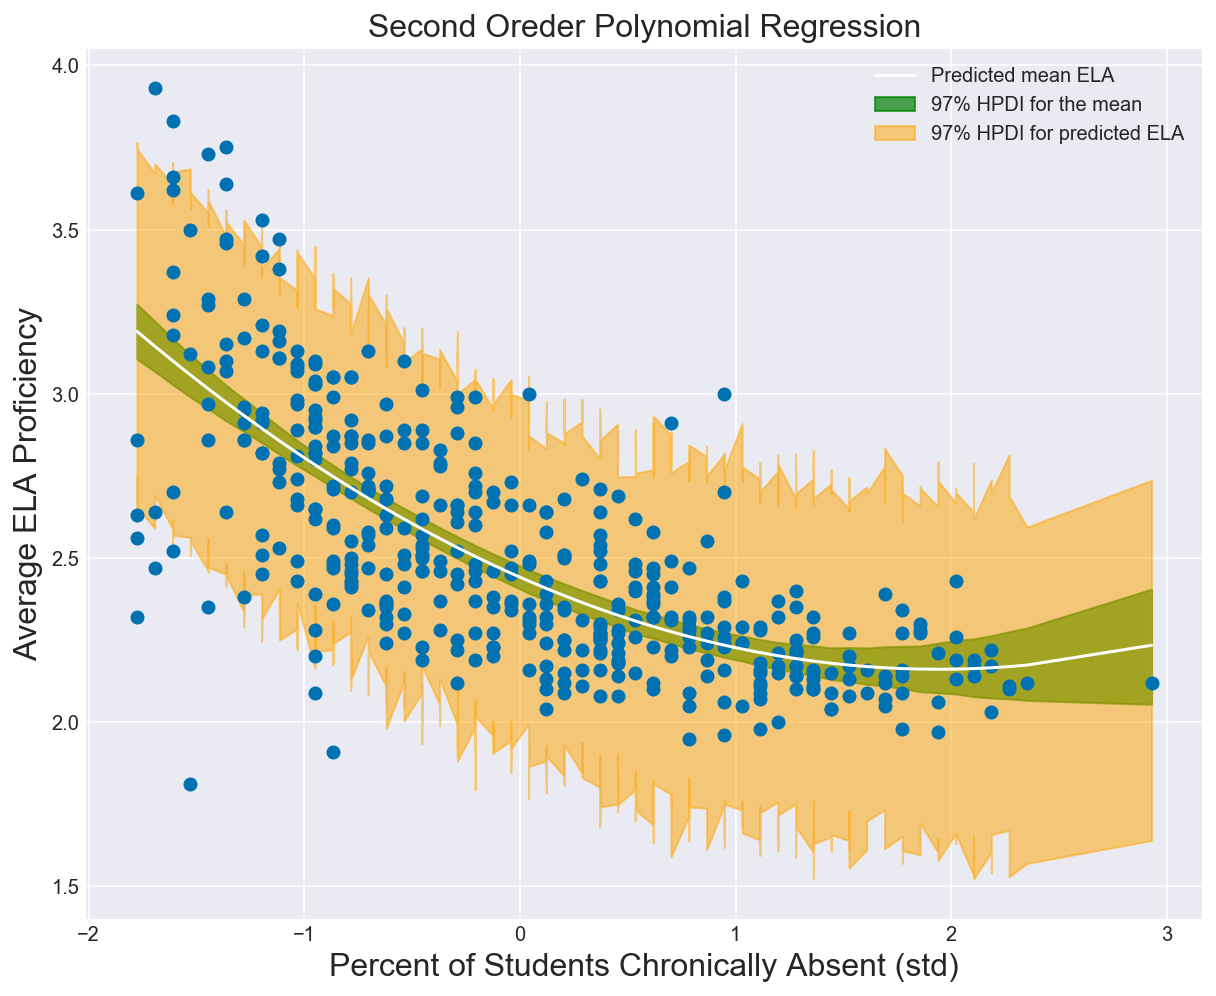

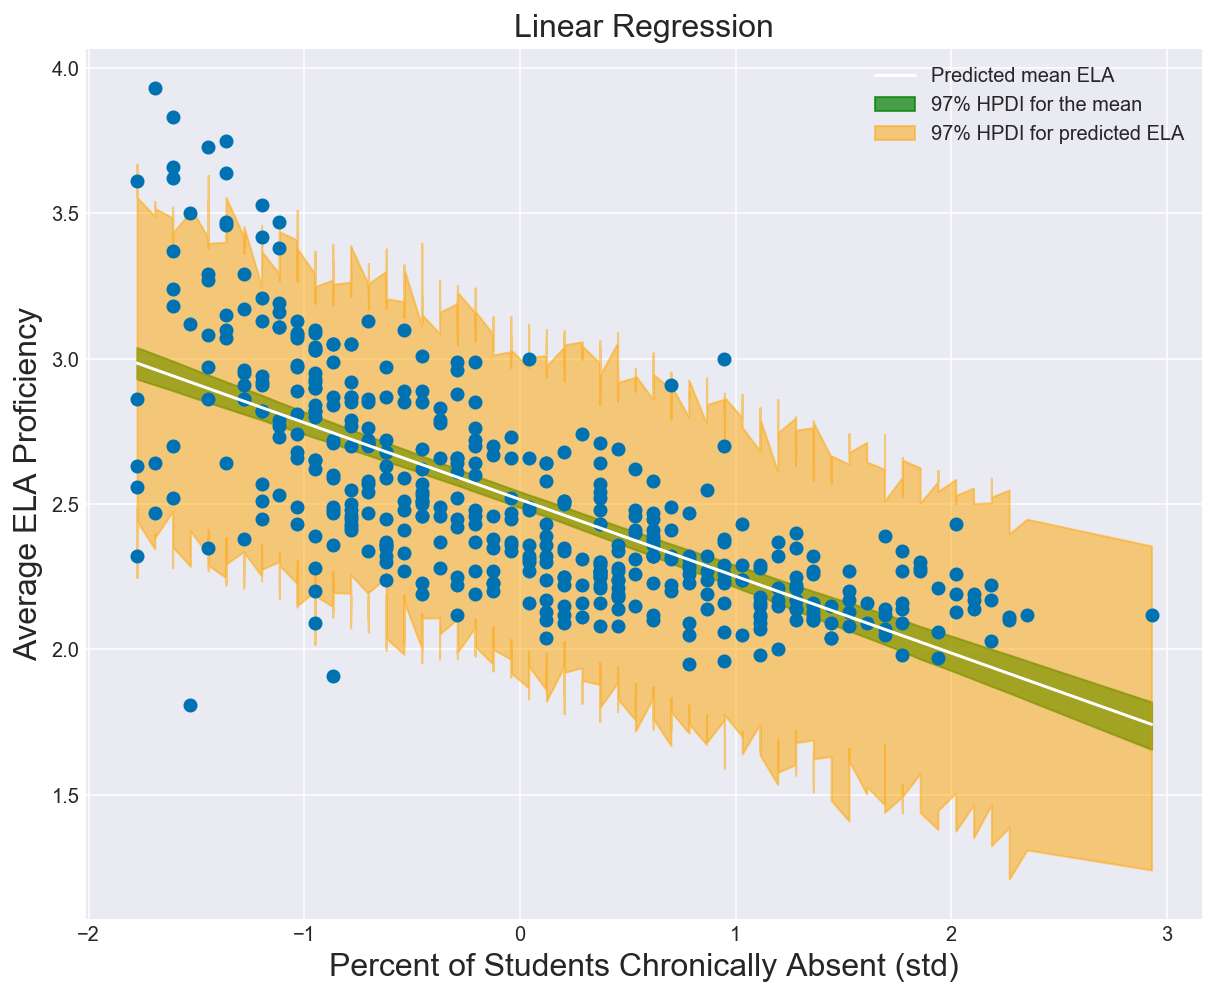

In [123]:
plt.figure(figsize=(10,8))

# plot the Chronic absences vs. ELA proficiencies
plt.plot(df2['stdized_absence'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of absences (this is the regression line)
plt.plot(df2['stdized_absence'], 
         trace_r_5['α'].mean() + 
         trace_r_5['β'][:,0].mean() * df2['stdized_absence'] + 
         trace_r_5['β'][:,1].mean() * df2['stdized_absence_2'],
         color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_absence'], mean_97_r5[:,0], mean_97_r5[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_absence'], pred_ELA_97_r5[:,0], pred_ELA_97_r5[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Second Oreder Polynomial Regression", fontsize=16)
plt.xlabel("Percent of Students Chronically Absent (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()

plt.show()
plt.close()

#--------------------------------------------------------------------------

plt.figure(figsize=(10,8))

# plot the Chronic absences vs. ELA proficiencies
plt.plot(df2['stdized_absence'], df2['Average ELA Proficiency'], 'o', label='')

# predicted mean ELA as a function of absences (this is the regression line)
plt.plot(df2['stdized_absence'], trace_r_1['α'].mean() + trace_r_1['β'].mean() * 
         df2['stdized_absence'], color='white', label='Predicted mean ELA')

# 97% highest probability density interval of the mean 
plt.fill_between(df2['stdized_absence'], mean_97_r1[:,0], mean_97_r1[:,1], 
                 alpha = 0.7, color='green', label='97% HPDI for the mean') 

# 97% highest probability density interval for predicted ELA proficiencies (includes standard deviation)
plt.fill_between(df2['stdized_absence'], pred_ELA_97_r1[:,0], pred_ELA_97_r1[:,1], 
                 alpha = 0.5, color='orange', label='97% HPDI for predicted ELA')

plt.title("Linear Regression", fontsize=16)
plt.xlabel("Percent of Students Chronically Absent (std)", fontsize=16)
plt.ylabel("Average ELA Proficiency", fontsize=16)
plt.legend()

plt.show()

Although the polynomial regression appears more aesthetic and to better fit the data than the linear regression, it has approximately the same number of data points outside the 97% HPD interval. It does seem to better fit the data at +2 standard deviations point. But neither models are a good fit for data that is < -1 standard deviations.

# Predict interval of mu for any of the predictor's value 

**Linear regresson, where predictor is Chronically Absent percentage**

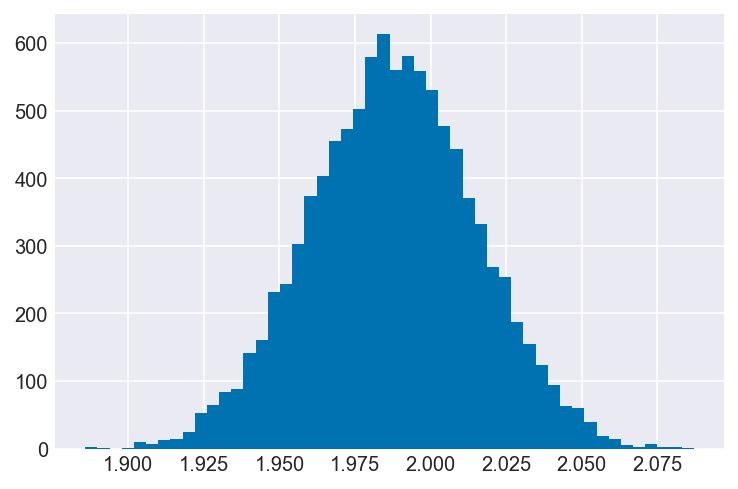

In [174]:
"""Compute the distribution of the mean of ELA proficiency when predictor is 2 standard deviation to the right
"""
g = trace_r_1['α'] + trace_r_1['β'] * 2
plt.hist(g, bins=50);

In [190]:
print("Convert +2 standard deviation to normal scale to understand what value it represents for the predictor:")
print(2*df2['Percent of Students Chronically Absent'].std() + 
      df2['Percent of Students Chronically Absent'].mean())
    
print("\nWhen the Chronically Absent percent of students is +2 standard deviations (45.7% chronically absent), \
the 89% HPDI of mu (does not include the std of the model predictions) \
for ELA proficiency is: {}".format(pm.hpd(g, alpha=0.11)))

Convert +2 standard deviation to normal scale to understand what value it represents for the predictor:
45.77686994949778

When the Chronically Absent percent of students is +2 standard deviations (45.7% chronically absent), the 89% HPDI of mu (does not include the std of the model predictions) for ELA proficiency is: [1.94348911 2.03157998]


**Polynomial regression, where predictor is Chronically Absent percentage**

# ????????????????????????????????????????????

this is still wrong. Don't use.


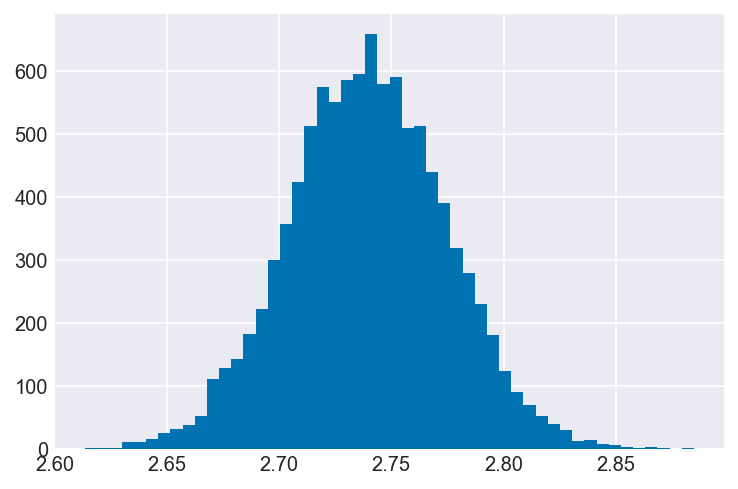

In [164]:
g2 = trace_r_5['α'] + trace_r_5['β'][:,1] * 2 + trace_r_5['β'][:,1] * 2
plt.hist(g2, bins=50);
print ("this is still wrong. Don't use.")

# Sampling Distribution of Priors

In [213]:
with pm.Model() as r_10:
    α = pm.Normal('α', 0, 5)
    β = pm.Normal('β', 0, 10)
    σ = pm.Uniform('σ', 0, 10)
    prior = pm.sample_prior_predictive()

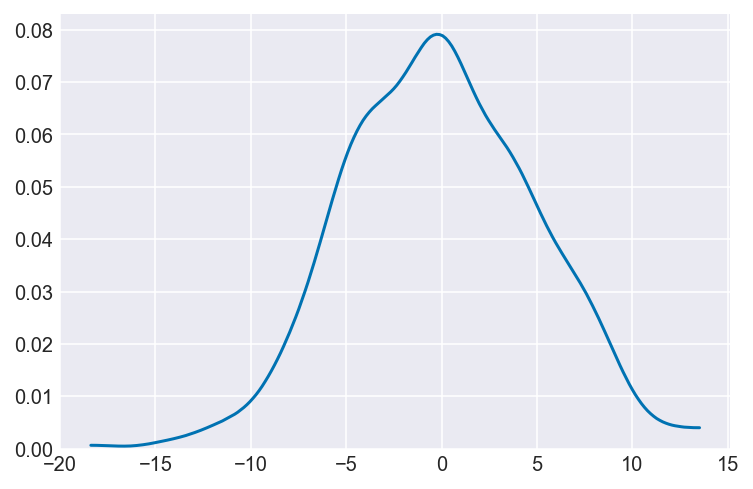

In [238]:
pm.kdeplot(prior['α']);